In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import numpy as np

# Gráficos de ganancia de ensembles

1) Leemos los archiovs csv de predicciones ordenadas por probabilidad descendente (archivos "predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+).csv")
   * a) Estos archivos tienen una línea por cliente identificado por  "numero_de_cliente"
   * b) La columna "peso" (1,2,3) indica la clase verdadera del cliente (CONTINUA, BAJA+1,  BAJA+2)
   * c) La columna "probabilidad" es la probabilidad asignada por el modelo de que el cliente pertenezca a la clase "BAJA+2"
   * d) En el nombre del archivo, lo que está entre "Compe_02_" y "_mes" sirve para identificar el modelo
   + e) La columna "semilla modelo" indica la semilla usada para entrenar el modelo (cada modelo se entrena con 20 semillas distintas)
   + f) En el nombre del archivo, entre "_mes_" y "_semilla" está el mes en el que se evaluó la predicción

2) Se grafican con estos datos:
    * a) Para cada modelo y mes de testeo, las curvas de ganancia (ganancia vs cantidad de clientes a los que se envía el estímulo) para cada semilla, y el promedio de las ganancias de todas las semillas. 
    * b) Para cada mes, la comparación de las curvas de ganancia promedio de los distintos modelos

Procesando 122 archivos...

--- Generando Gráficos Detallados (Semillas + Promedio) ---


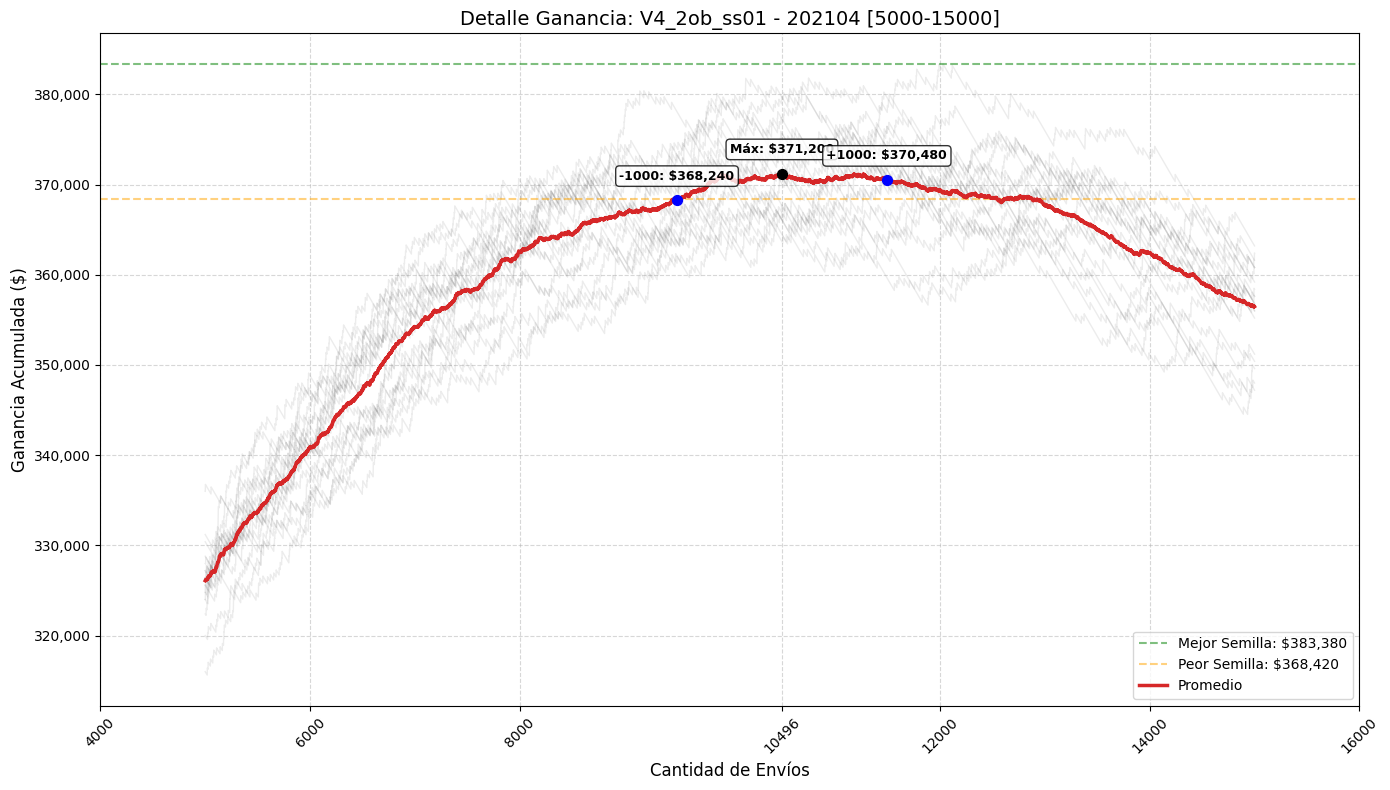

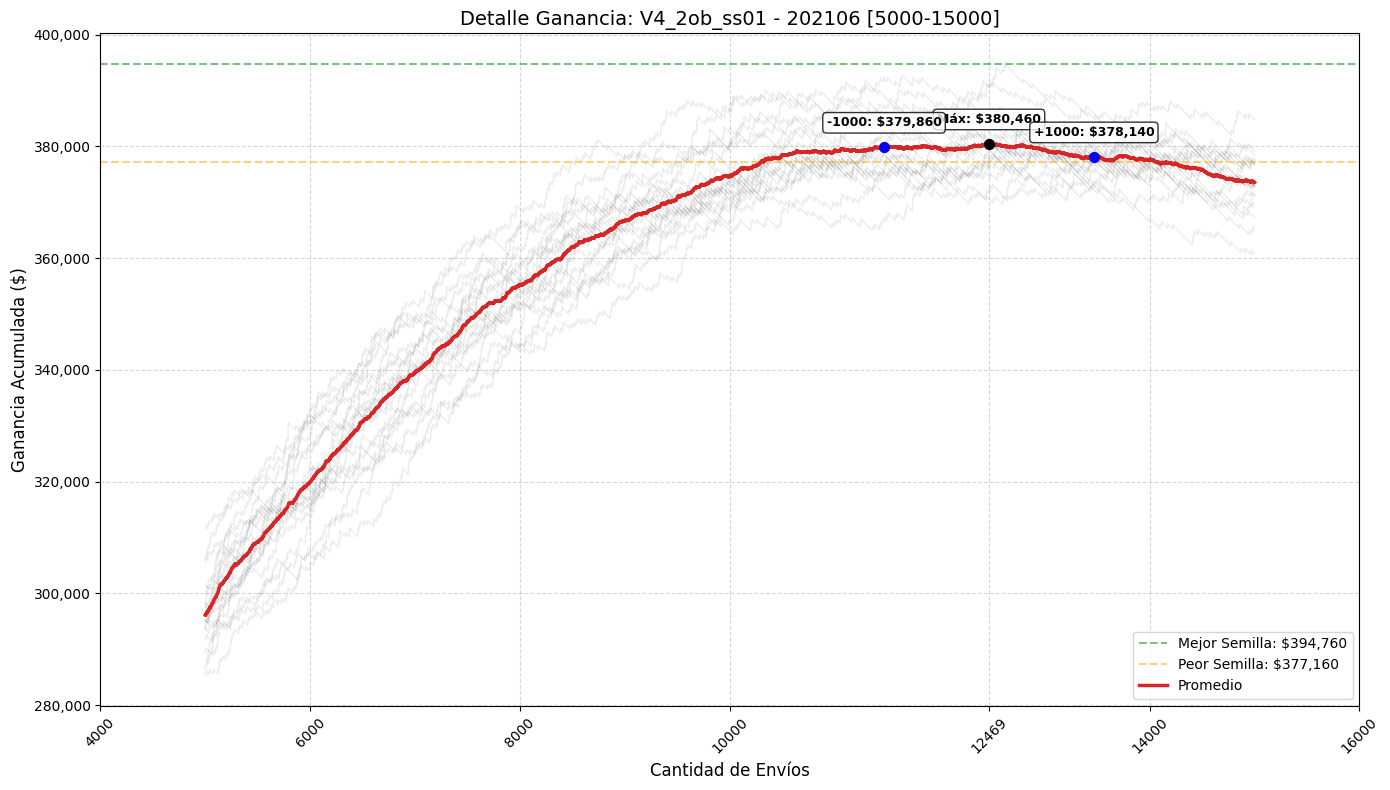

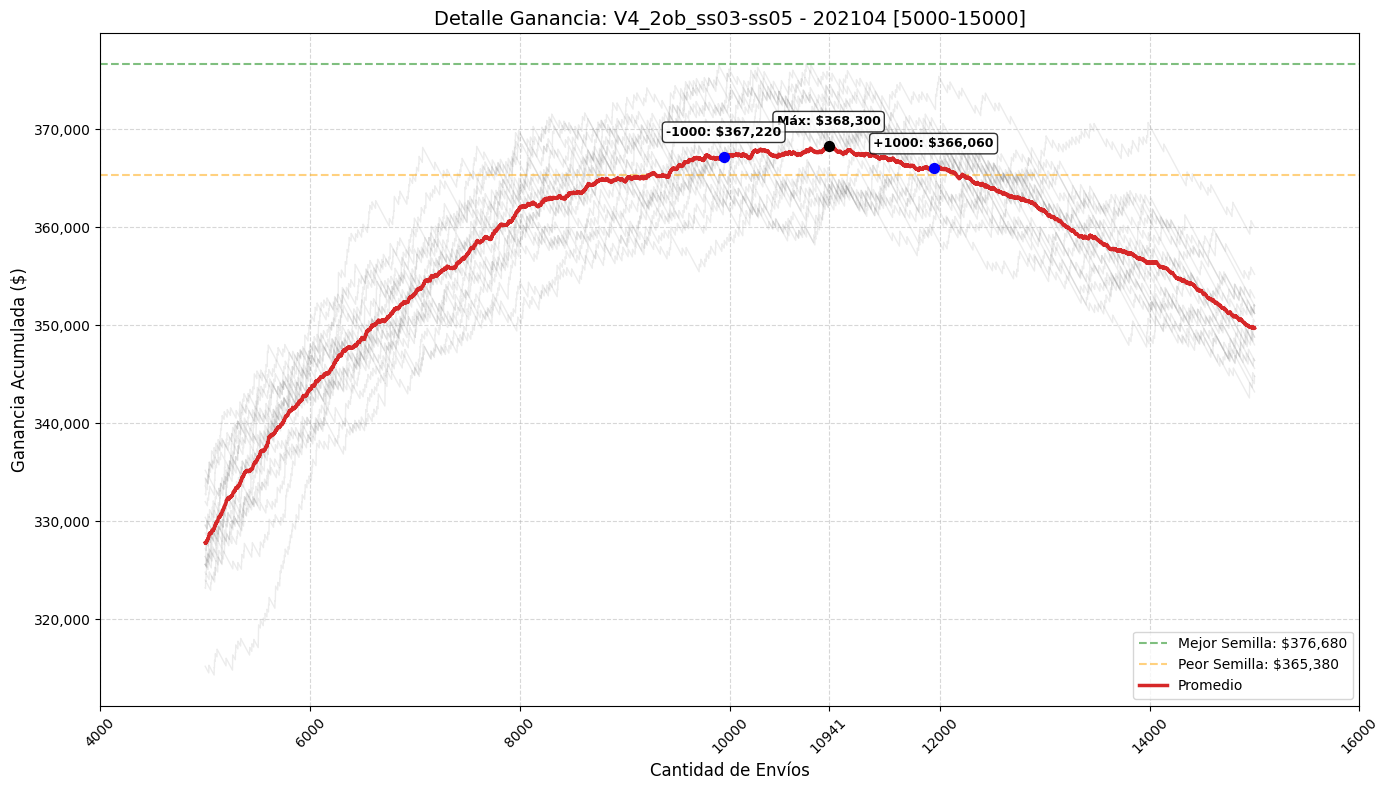

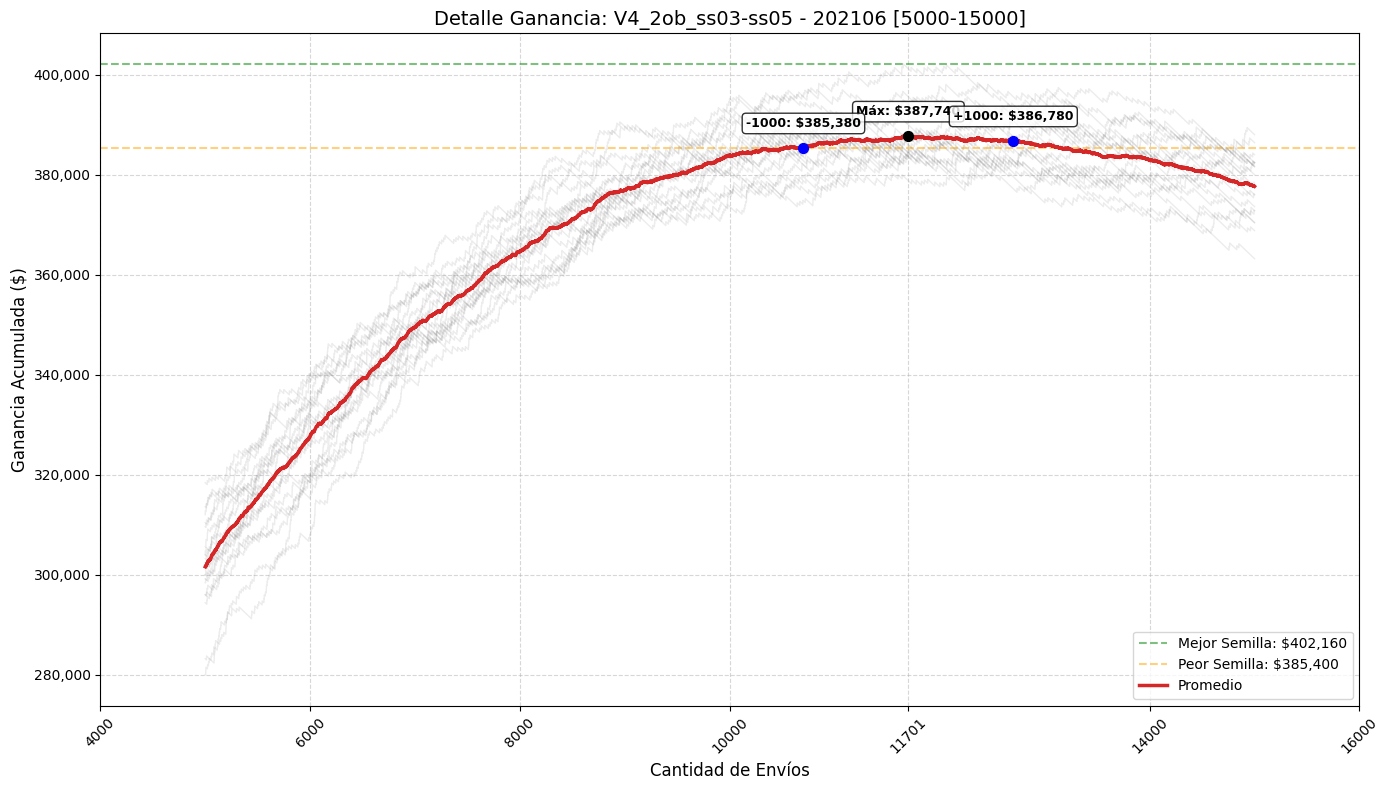

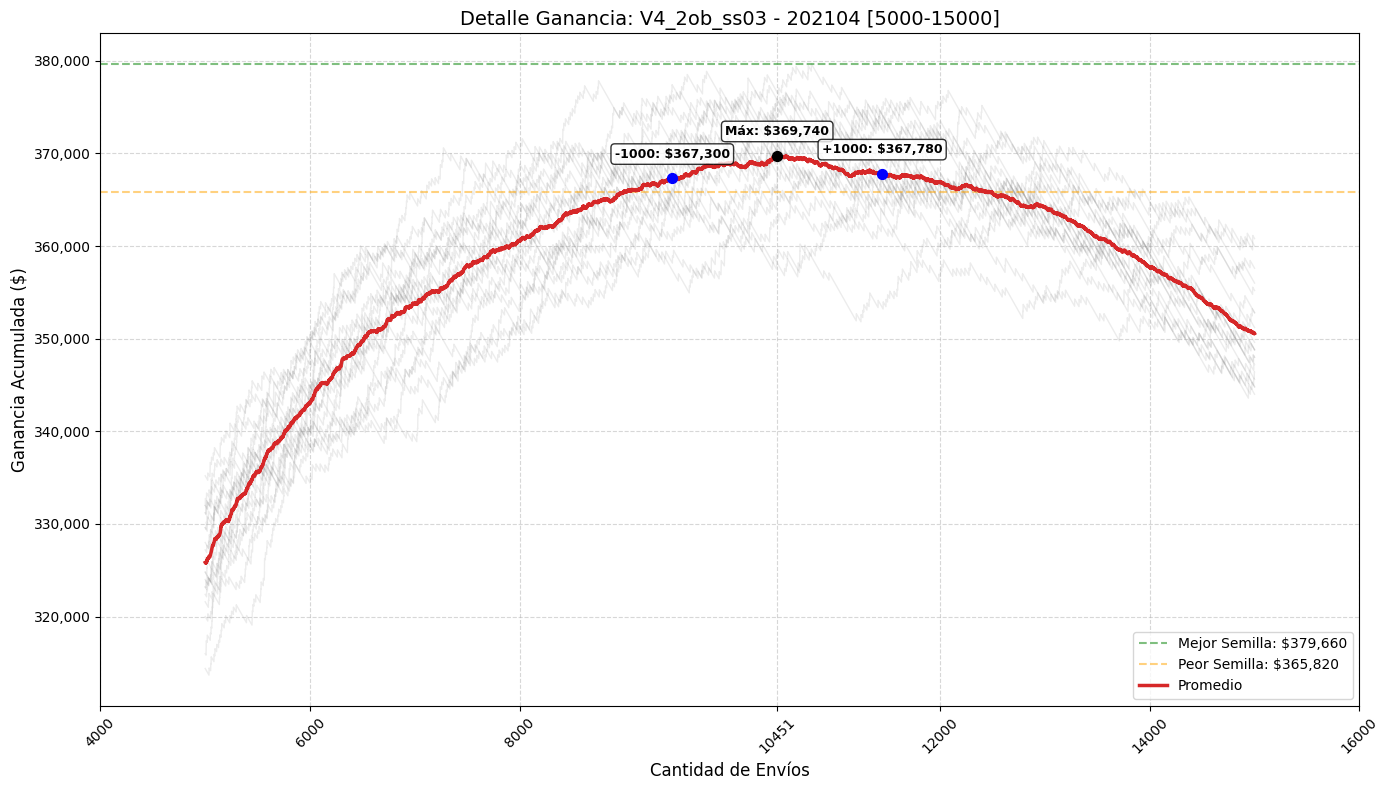

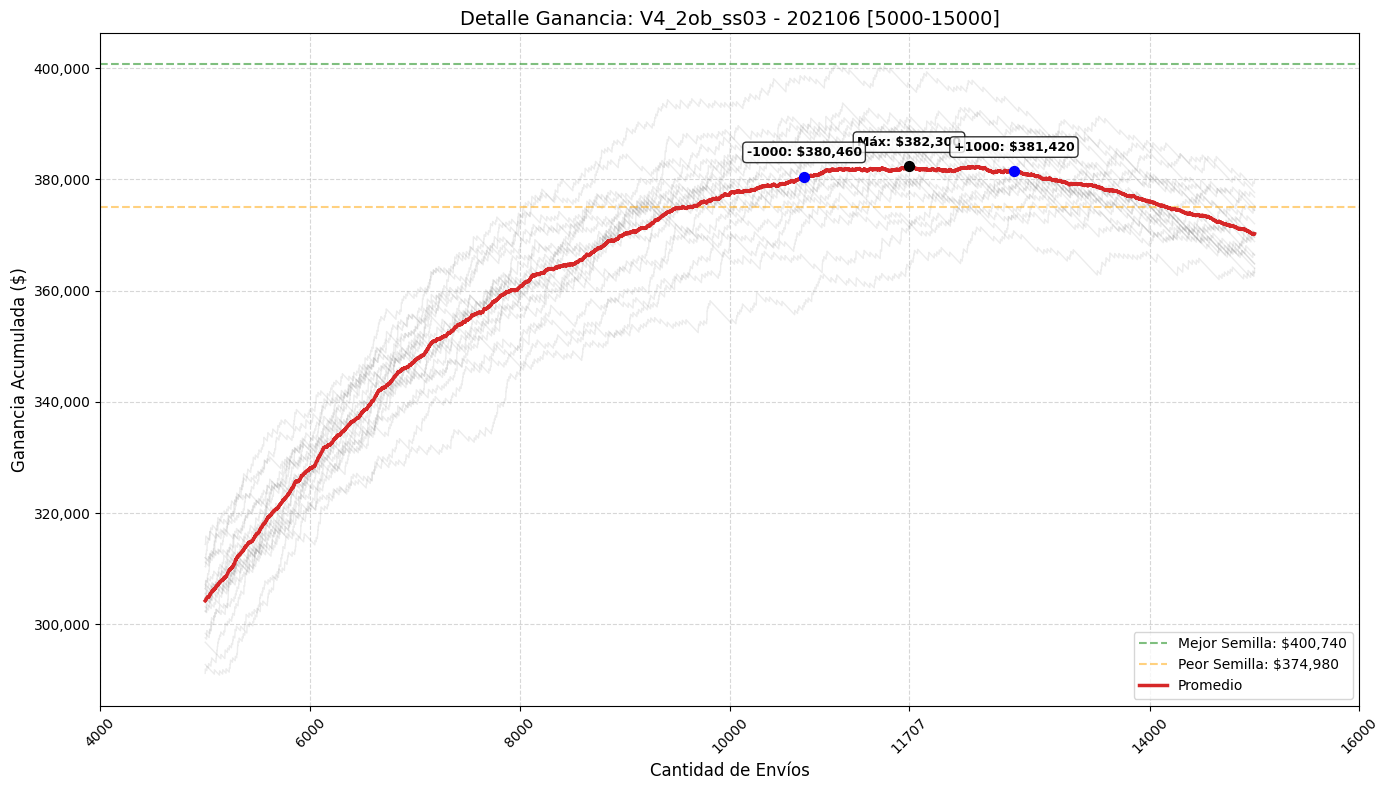


--- Generando Gráficos Comparativos (Promedios por Mes) ---


C:\Users\terang\AppData\Local\Temp\ipykernel_26880\4085597559.py:146: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', 10)


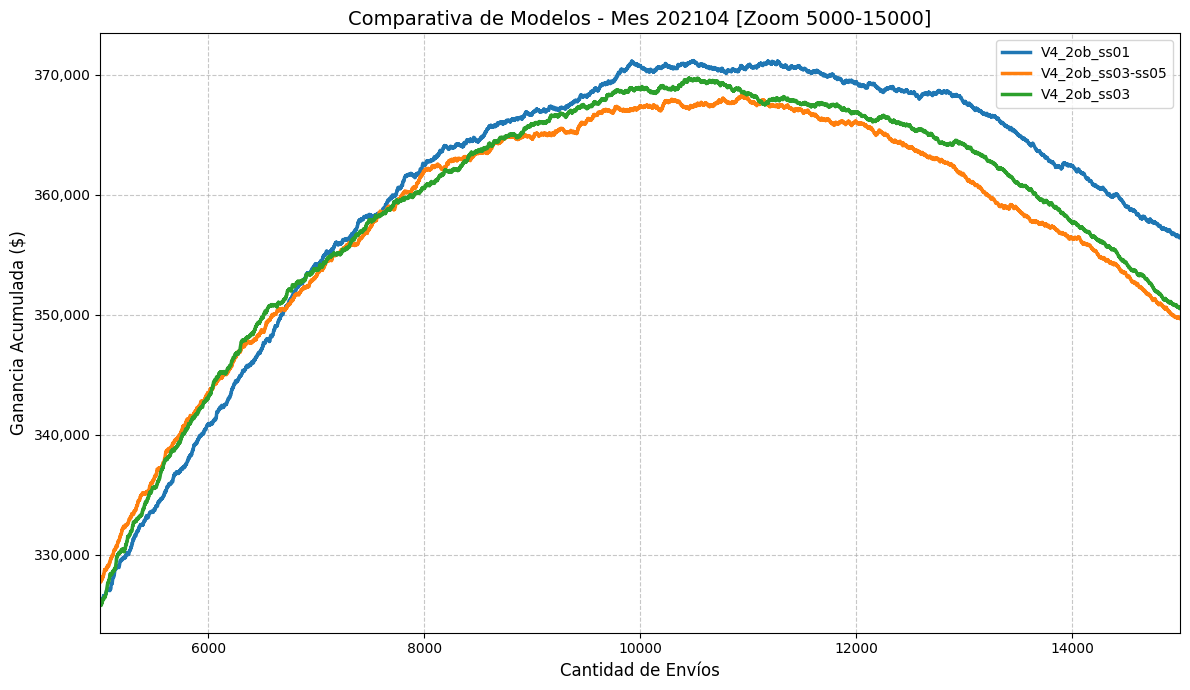

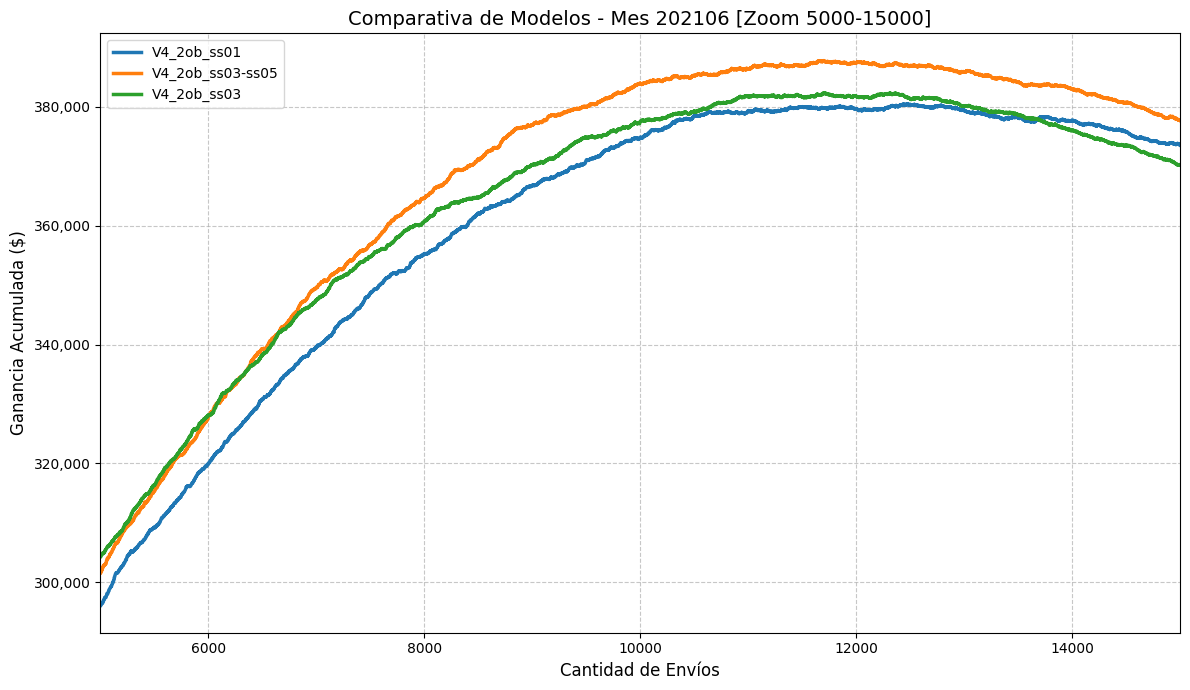

In [12]:
# ================= CONFIGURACIÓN =================
RUTA_CARPETA = './colaborativos' 

# ================= CONFIGURACIÓN =================

GANANCIA_UNITARIA = 780
COSTO_UNITARIO = -20

# Eje X: Cantidad de Envíos (Clientes)
X_LIM_MIN = 5000    
X_LIM_MAX = 15000   

# Eje Y: Ganancia ($) (None = automático)
Y_LIM_MIN = 200 
Y_LIM_MAX = None 

PATRON_REGEX = r"predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+)"
# =================================================

def formatear_moneda(valor):
    return f"${int(valor):,}"

def procesar_archivos():
    archivos = glob.glob(os.path.join(RUTA_CARPETA, "*.csv"))
    if not archivos:
        print("No se encontraron archivos .csv")
        return

    datos_agrupados = {}
    print(f"Procesando {len(archivos)} archivos...")

    for archivo in archivos:
        nombre_archivo = os.path.basename(archivo)
        match = re.search(PATRON_REGEX, nombre_archivo)
        if match:
            llave = (match.group(1), match.group(2)) # (Modelo, Mes)
            
            try:
                df = pd.read_csv(archivo)
                df['ganancia'] = np.where(df['clase_peso'] == 3, GANANCIA_UNITARIA, COSTO_UNITARIO)
                df['ganancia_acumulada'] = df['ganancia'].cumsum()
                df['envios'] = np.arange(1, len(df) + 1)
                
                # Recortamos datos (un poco más allá del límite) para optimizar RAM
                df_plot = df[df['envios'] <= (X_LIM_MAX + 5000)][['envios', 'ganancia_acumulada']].copy()
                
                if llave not in datos_agrupados:
                    datos_agrupados[llave] = []
                datos_agrupados[llave].append(df_plot)
            except Exception as e:
                print(f"Error leyendo {nombre_archivo}: {e}")

    # --- NUEVA ESTRUCTURA PARA GUARDAR PROMEDIOS ---
    # Almacenará: {'mes_1': [('modelo_A', df_prom_A), ('modelo_B', df_prom_B)], 'mes_2': [...]}
    promedios_por_mes = {}

    # --- GRAFICACIÓN 1: DETALLE POR MODELO-MES (Semillas + Promedio) ---
    print("\n--- Generando Gráficos Detallados (Semillas + Promedio) ---")
    
    for (modelo, mes), lista_dfs in datos_agrupados.items():
        fig, ax = plt.subplots(figsize=(14, 8))
        
        maximos_por_semilla = []

        # 1. Curvas individuales
        for df_semilla in lista_dfs:
            mask = (df_semilla['envios'] >= X_LIM_MIN) & (df_semilla['envios'] <= X_LIM_MAX)
            segmento = df_semilla[mask]
            
            if not segmento.empty:
                ax.plot(segmento['envios'], segmento['ganancia_acumulada'], 
                        color='gray', alpha=0.15, linewidth=1)
            
            maximos_por_semilla.append(df_semilla['ganancia_acumulada'].max())

        # 2. Líneas de Rango (Max-Max y Min-Max)
        if maximos_por_semilla:
            max_de_maximos = max(maximos_por_semilla)
            min_de_maximos = min(maximos_por_semilla)
            ax.axhline(y=max_de_maximos, color='green', linestyle='--', alpha=0.5, label=f'Mejor Semilla: {formatear_moneda(max_de_maximos)}')
            ax.axhline(y=min_de_maximos, color='orange', linestyle='--', alpha=0.5, label=f'Peor Semilla: {formatear_moneda(min_de_maximos)}')

        # 3. Curva Promedio
        if lista_dfs:
            df_concat = pd.concat(lista_dfs)
            df_promedio = df_concat.groupby('envios')['ganancia_acumulada'].mean()
            
            # --- !! GUARDAMOS EL PROMEDIO !! ---
            if mes not in promedios_por_mes:
                promedios_por_mes[mes] = []
            promedios_por_mes[mes].append((modelo, df_promedio.copy()))
            # --- Fin del guardado ---

            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            ax.plot(df_prom_plot.index, df_prom_plot.values, color='#D62728', linewidth=2.5, label='Promedio')

            # --- Puntos Clave ---
            x_optimo = df_promedio.idxmax()
            y_optimo = df_promedio.max()
            puntos_interes = [x_optimo]
            etiquetas = [f"Máx: {formatear_moneda(y_optimo)}"]
            colores = ['black']

            for offset in [-1000, 1000]:
                x_vecino = x_optimo + offset
                if x_vecino in df_promedio.index:
                    y_vecino = df_promedio.loc[x_vecino]
                    puntos_interes.append(x_vecino)
                    etiquetas.append(f"{'+' if offset>0 else ''}{offset}: {formatear_moneda(y_vecino)}")
                    colores.append('blue')

            for x, y, txt, col in zip(puntos_interes, [df_promedio.loc[p] for p in puntos_interes], etiquetas, colores):
                if X_LIM_MIN <= x <= X_LIM_MAX:
                    ax.scatter([x], [y], color=col, zorder=5, s=50)
                    ax.annotate(txt, (x, y), xytext=(0, 15), textcoords='offset points', 
                                ha='center', fontsize=9, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            # --- Ejes y Ticks ---
            ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
            if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
                ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
            
            ticks = list(ax.get_xticks())
            if X_LIM_MIN <= x_optimo <= X_LIM_MAX:
                ticks = [t for t in ticks if abs(t - x_optimo) > ((X_LIM_MAX - X_LIM_MIN)/15)]
                ticks.append(x_optimo)
                ticks.sort()
                ax.set_xticks(ticks)
            plt.xticks(rotation=45)

        # Formato final
        plt.title(f"Detalle Ganancia: {modelo} - {mes} [{X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        plt.xlabel("Cantidad de Envíos", fontsize=12)
        plt.ylabel("Ganancia Acumulada ($)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='lower right')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

    # --- GRAFICACIÓN 2: COMPARATIVA POR MES (Solo Promedios) ---
    print("\n--- Generando Gráficos Comparativos (Promedios por Mes) ---")

    # Usamos un mapa de color para dar un color distinto a cada modelo
    colores = plt.cm.get_cmap('tab10', 10) 

    for mes, lista_modelos_promedio in promedios_por_mes.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Iteramos sobre los modelos guardados para este mes
        for i, (modelo, df_promedio) in enumerate(lista_modelos_promedio):
            
            # Recortamos el promedio al zoom visual
            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            
            if not df_prom_plot.empty:
                ax.plot(df_prom_plot.index, df_prom_plot.values, 
                        label=modelo,  # La etiqueta es el nombre del modelo
                        color=colores(i % 10), 
                        linewidth=2.5)

        # --- Formato del gráfico comparativo ---
        ax.set_title(f"Comparativa de Modelos - Mes {mes} [Zoom {X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        ax.set_xlabel("Cantidad de Envíos", fontsize=12)
        ax.set_ylabel("Ganancia Acumulada ($)", fontsize=12)
        
        # Aplicamos los límites definidos
        ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
        if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
            ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best') # 'best' para que la leyenda se ponga donde menos tape
        
        # Formato miles eje Y
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        plt.tight_layout()
        plt.show()

if __name__ == '__main__':
    procesar_archivos()


# Gráficos de ganancia de ensembles

1) Leemos los archiovs csv de predicciones ordenadas por probabilidad descendente (archivos "predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+).csv")
   * a) Estos archivos tienen una línea por cliente identificado por  "numero_de_cliente"
   * b) La columna "peso" (1,2,3) indica la clase verdadera del cliente (CONTINUA, BAJA+1,  BAJA+2)
   * c) La columna "probabilidad" es la probabilidad asignada por el modelo de que el cliente pertenezca a la clase "BAJA+2"
   * d) En el nombre del archivo, lo que está entre "Compe_02_" y "_mes" sirve para identificar el modelo
   + e) La columna "semilla modelo" indica la semilla usada para entrenar el modelo (cada modelo se entrena con 20 semillas distintas)
   + f) En el nombre del archivo, entre "_mes_" y "_semilla" está el mes en el que se evaluó la predicción

2) Se grafican con estos datos:
    * a) Para cada modelo y mes de testeo, las curvas de ganancia (ganancia vs cantidad de clientes a los que se envía el estímulo) para cada semilla, y el promedio de las ganancias de todas las semillas. 
    * b) Para cada mes, la comparación de las curvas de ganancia promedio de los distintos modelos
    * c) Ganancias de los ensembles de todos los modelos para cada mes

Procesando 122 archivos...

--- Generando Gráficos Detallados (Semillas + Promedio) ---


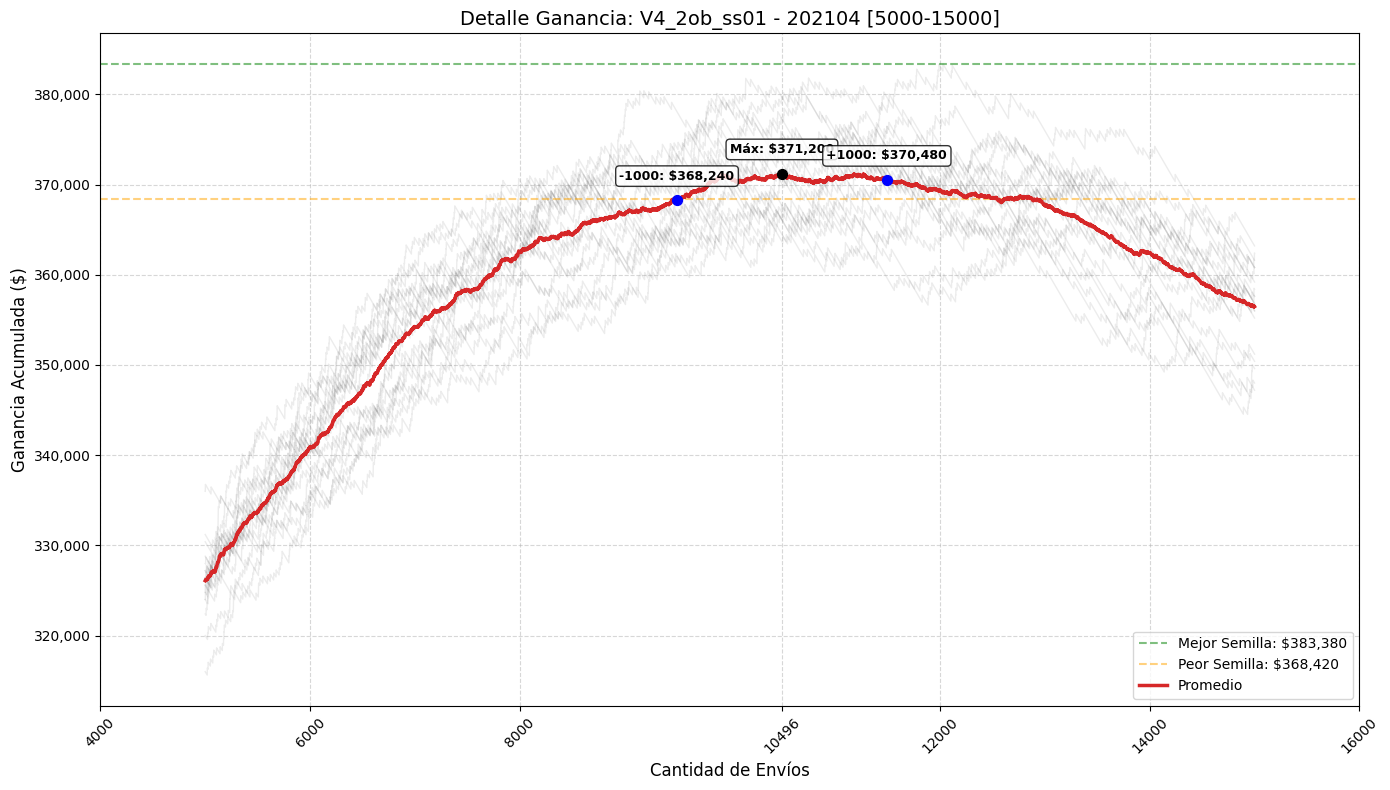

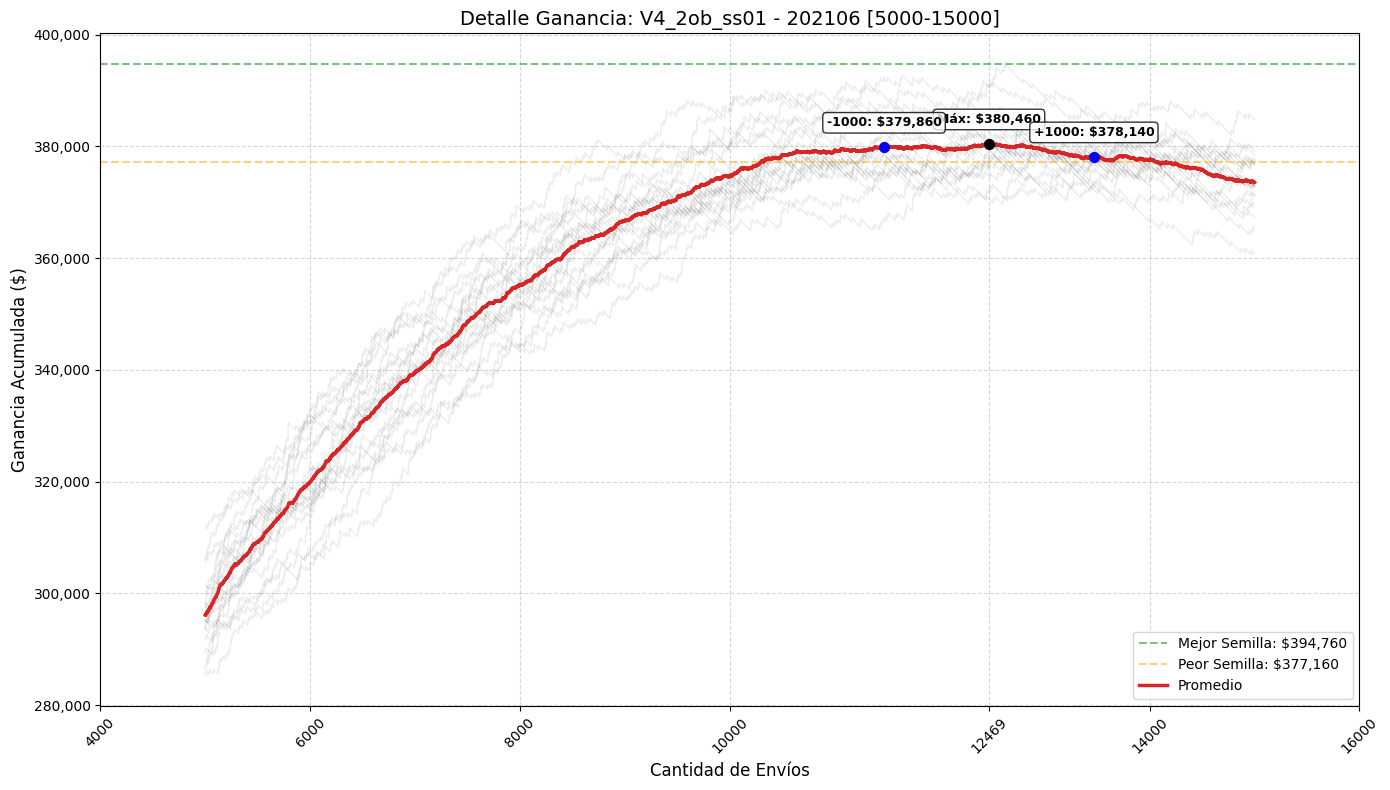

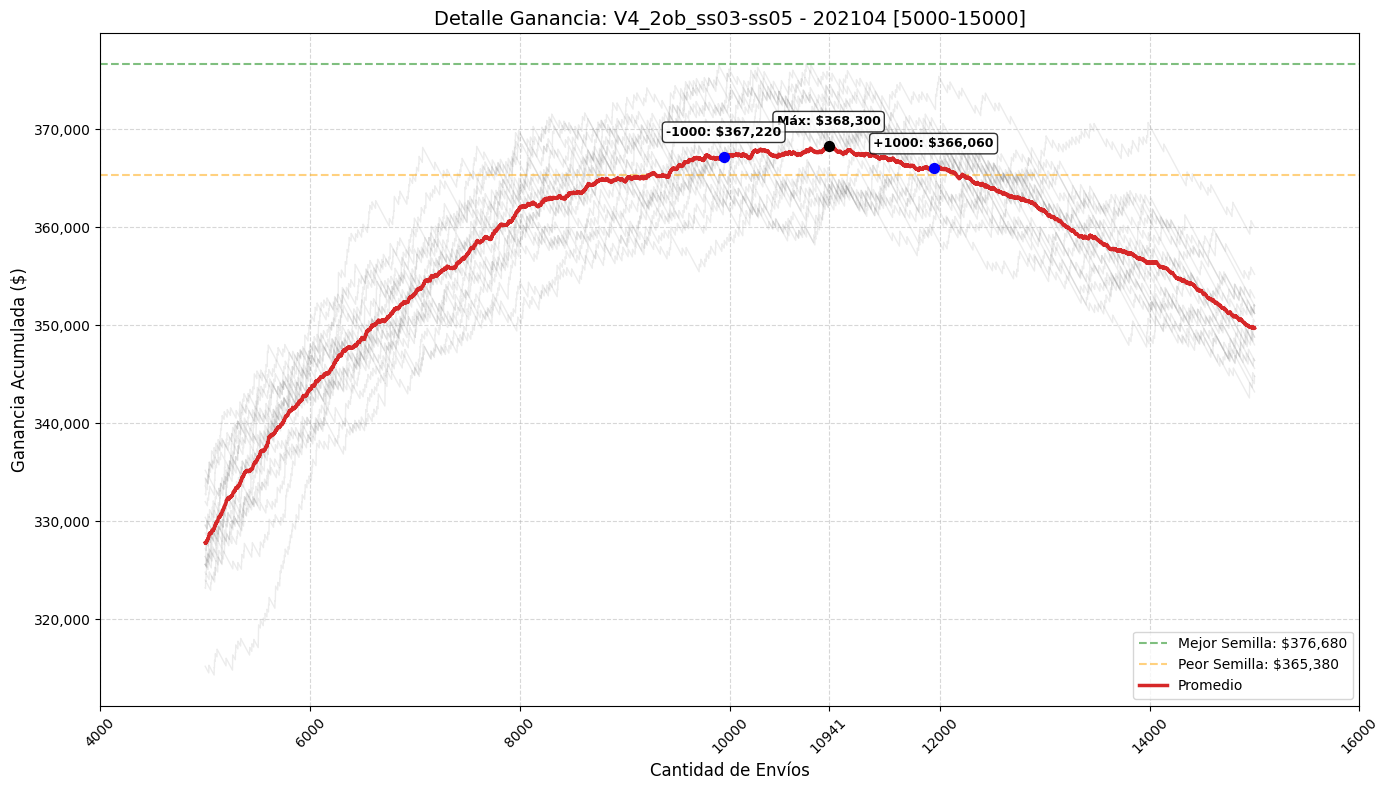

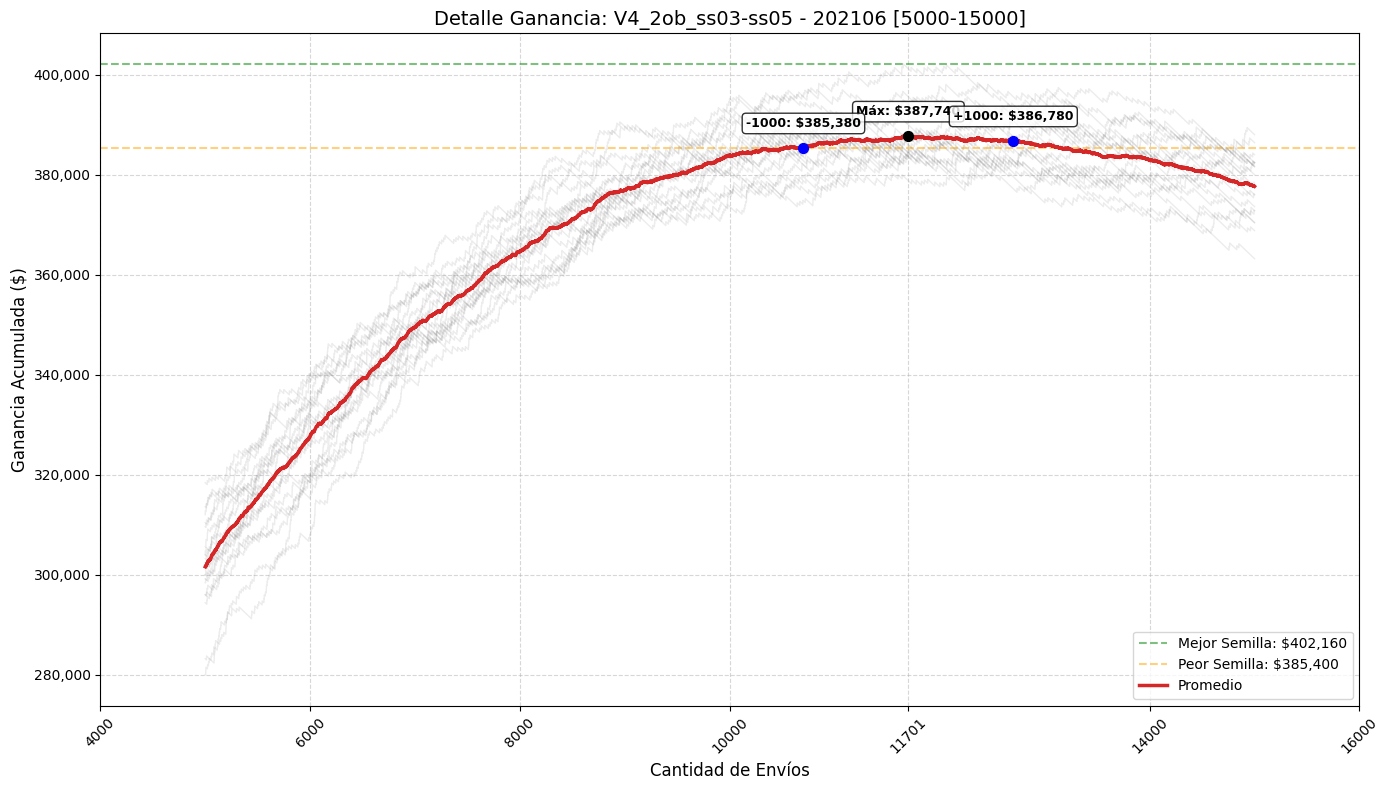

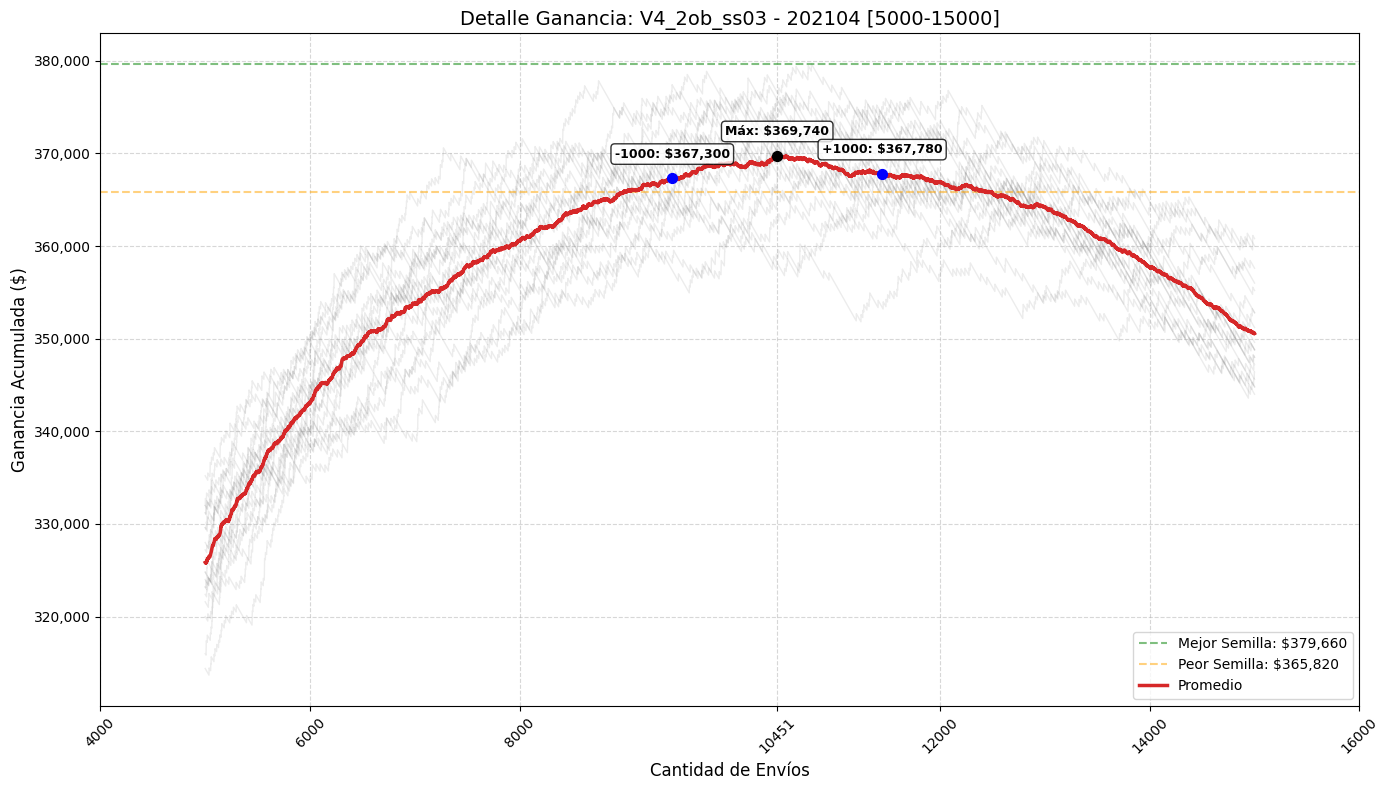

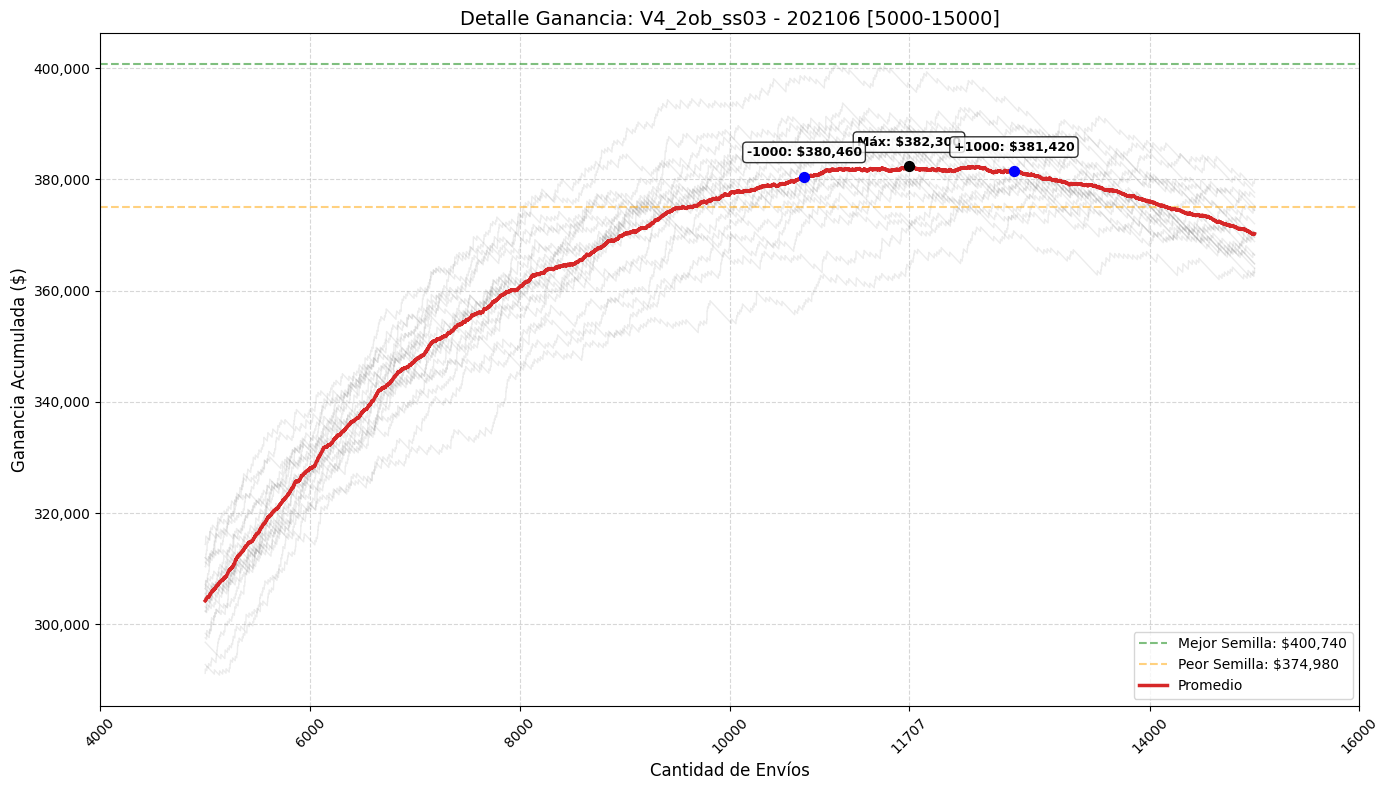


--- Generando Gráficos Comparativos (Promedios por Mes) ---


C:\Users\terang\AppData\Local\Temp\ipykernel_26880\498077785.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', 10)


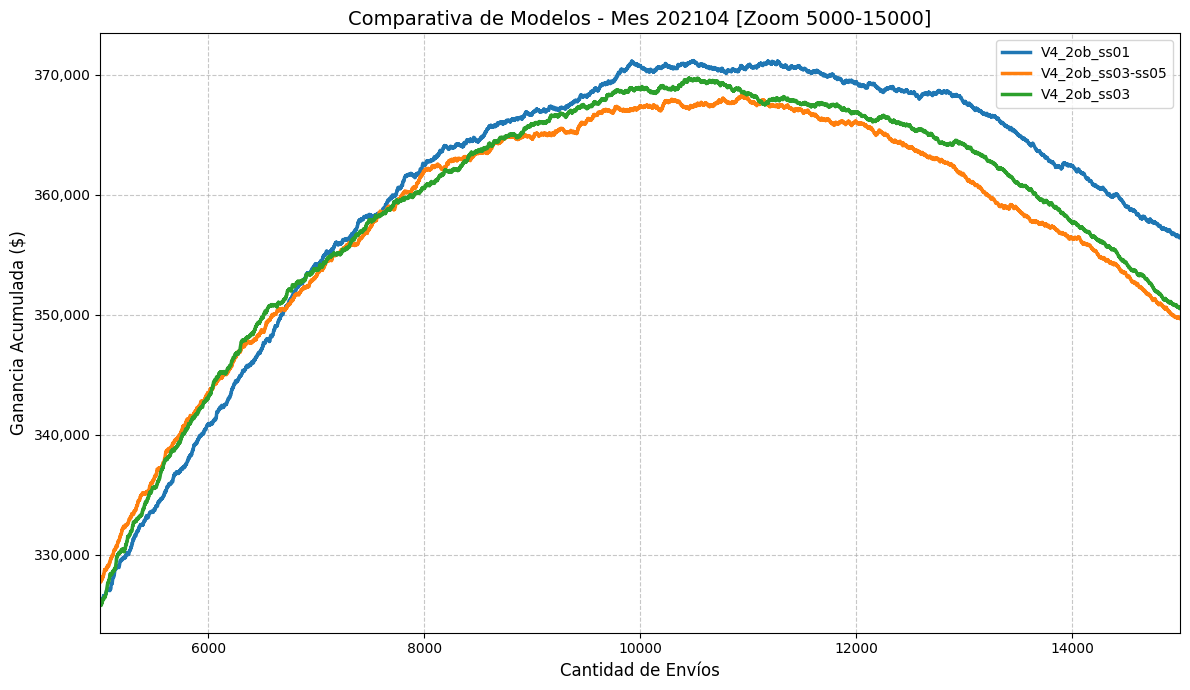

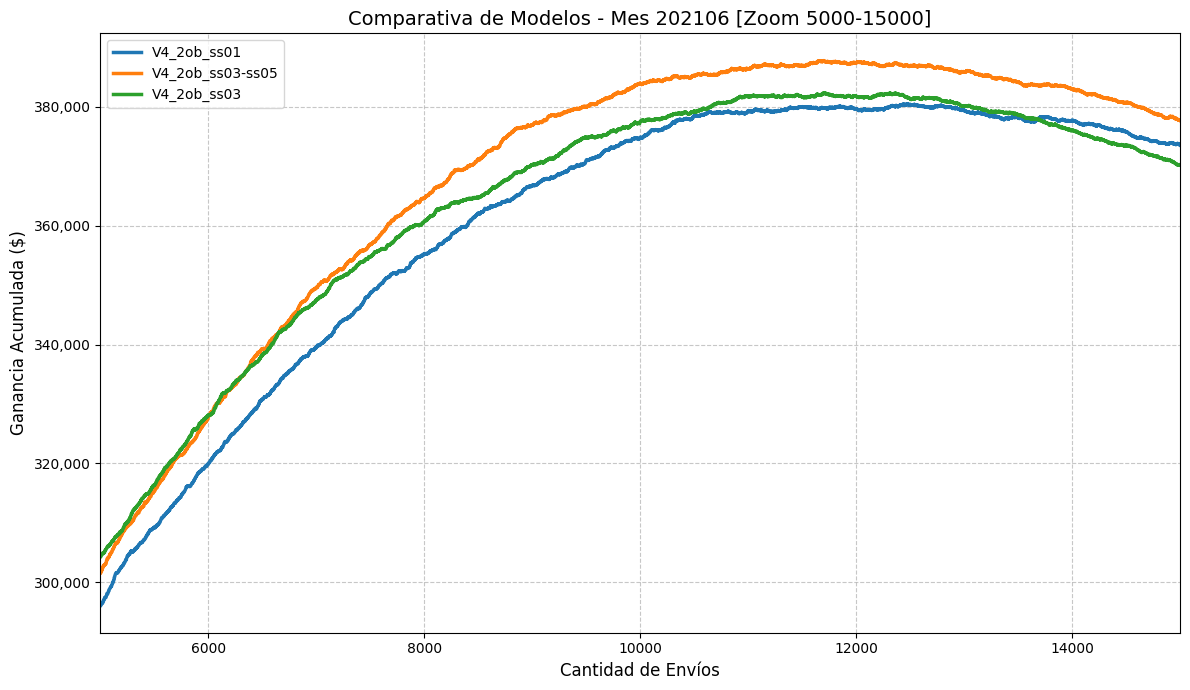


--- Iniciando Proceso de Ensemble ---
Cargando todos los archivos para el ensemble...
Paso 1: Calculando promedio por modelo (semillas)...
Paso 2: Calculando promedio de ensemble (modelos)...
Paso 3: Generando gráficos de ganancia del ensemble...


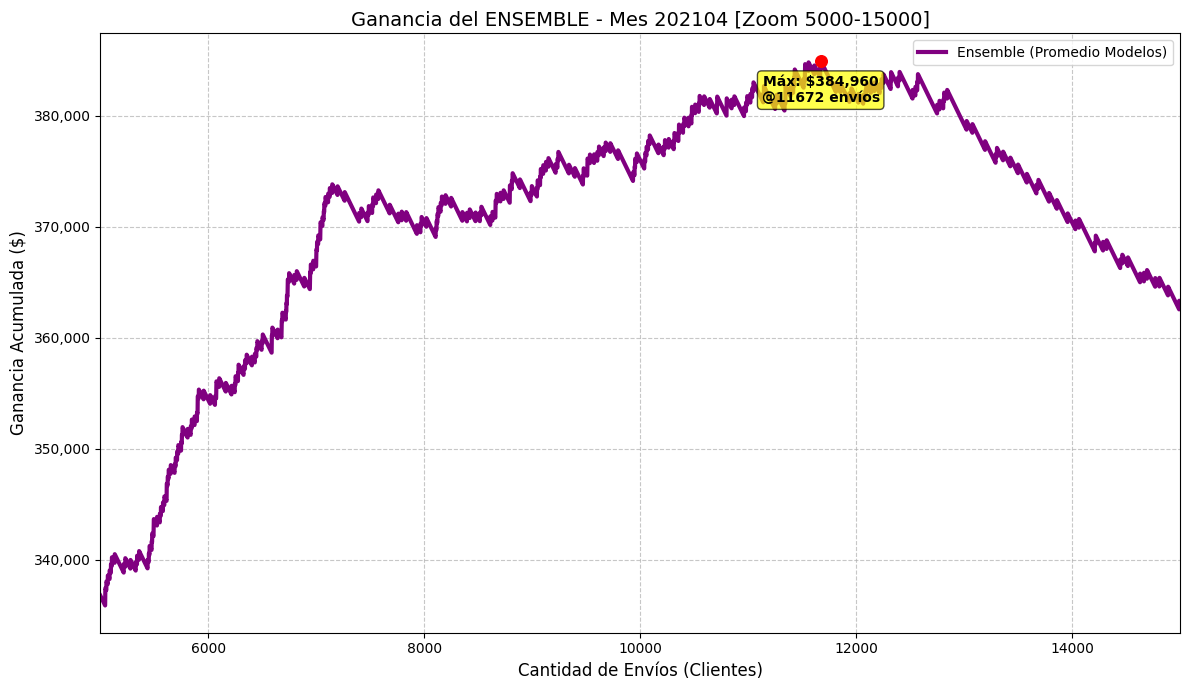

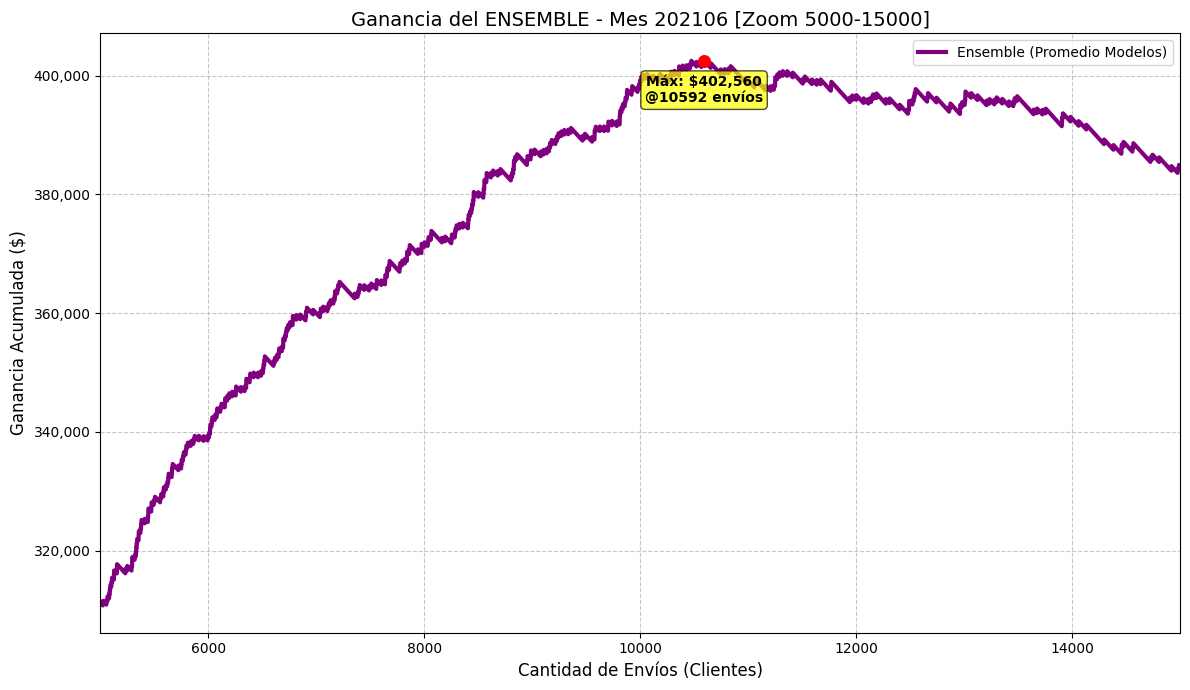

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import os
import numpy as np

# ================= CONFIGURACIÓN =================
RUTA_CARPETA = './colaborativos' 
GANANCIA_UNITARIA = 780
COSTO_UNITARIO = -20

# Eje X: Cantidad de Envíos (Clientes)
X_LIM_MIN = 5000    
X_LIM_MAX = 15000   

# Eje Y: Ganancia ($) (None = automático)
Y_LIM_MIN = 200 
Y_LIM_MAX = None 

PATRON_REGEX = r"predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+)"
# =================================================

def formatear_moneda(valor):
    """Función helper para formatear números como moneda"""
    return f"${int(valor):,}"

def procesar_archivos():
    """
    Función 1: Procesa y grafica los modelos individualmente 
    (semillas + promedio) y la comparativa de promedios.
    """
    archivos = glob.glob(os.path.join(RUTA_CARPETA, "*.csv"))
    if not archivos:
        print("No se encontraron archivos .csv en procesar_archivos()")
        return

    datos_agrupados = {}
    print(f"Procesando {len(archivos)} archivos...")

    for archivo in archivos:
        nombre_archivo = os.path.basename(archivo)
        match = re.search(PATRON_REGEX, nombre_archivo)
        if match:
            llave = (match.group(1), match.group(2)) # (Modelo, Mes)
            
            try:
                df = pd.read_csv(archivo)
                df['ganancia'] = np.where(df['clase_peso'] == 3, GANANCIA_UNITARIA, COSTO_UNITARIO)
                df['ganancia_acumulada'] = df['ganancia'].cumsum()
                df['envios'] = np.arange(1, len(df) + 1)
                
                df_plot = df[df['envios'] <= (X_LIM_MAX + 5000)][['envios', 'ganancia_acumulada']].copy()
                
                if llave not in datos_agrupados:
                    datos_agrupados[llave] = []
                datos_agrupados[llave].append(df_plot)
            except Exception as e:
                print(f"Error leyendo {nombre_archivo}: {e}")

    promedios_por_mes = {}

    # --- GRAFICACIÓN 1: DETALLE POR MODELO-MES ---
    print("\n--- Generando Gráficos Detallados (Semillas + Promedio) ---")
    
    for (modelo, mes), lista_dfs in datos_agrupados.items():
        fig, ax = plt.subplots(figsize=(14, 8))
        
        maximos_por_semilla = []

        # Curvas individuales
        for df_semilla in lista_dfs:
            mask = (df_semilla['envios'] >= X_LIM_MIN) & (df_semilla['envios'] <= X_LIM_MAX)
            segmento = df_semilla[mask]
            
            if not segmento.empty:
                ax.plot(segmento['envios'], segmento['ganancia_acumulada'], 
                        color='gray', alpha=0.15, linewidth=1)
            
            maximos_por_semilla.append(df_semilla['ganancia_acumulada'].max())

        # Líneas de Rango
        if maximos_por_semilla:
            max_de_maximos = max(maximos_por_semilla)
            min_de_maximos = min(maximos_por_semilla)
            ax.axhline(y=max_de_maximos, color='green', linestyle='--', alpha=0.5, label=f'Mejor Semilla: {formatear_moneda(max_de_maximos)}')
            ax.axhline(y=min_de_maximos, color='orange', linestyle='--', alpha=0.5, label=f'Peor Semilla: {formatear_moneda(min_de_maximos)}')

        # Curva Promedio
        if lista_dfs:
            df_concat = pd.concat(lista_dfs)
            df_promedio = df_concat.groupby('envios')['ganancia_acumulada'].mean()
            
            # Guardamos el promedio para la Gráfica 2
            if mes not in promedios_por_mes:
                promedios_por_mes[mes] = []
            promedios_por_mes[mes].append((modelo, df_promedio.copy()))

            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            ax.plot(df_prom_plot.index, df_prom_plot.values, color='#D62728', linewidth=2.5, label='Promedio')

            # Puntos Clave
            x_optimo = df_promedio.idxmax()
            y_optimo = df_promedio.max()
            puntos_interes = [x_optimo]
            etiquetas = [f"Máx: {formatear_moneda(y_optimo)}"]
            colores = ['black']

            for offset in [-1000, 1000]:
                x_vecino = x_optimo + offset
                if x_vecino in df_promedio.index:
                    y_vecino = df_promedio.loc[x_vecino]
                    puntos_interes.append(x_vecino)
                    etiquetas.append(f"{'+' if offset>0 else ''}{offset}: {formatear_moneda(y_vecino)}")
                    colores.append('blue')

            for x, y, txt, col in zip(puntos_interes, [df_promedio.loc[p] for p in puntos_interes], etiquetas, colores):
                if X_LIM_MIN <= x <= X_LIM_MAX:
                    ax.scatter([x], [y], color=col, zorder=5, s=50)
                    ax.annotate(txt, (x, y), xytext=(0, 15), textcoords='offset points', 
                                ha='center', fontsize=9, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            # Ejes y Ticks
            ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
            if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
                ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
            
            ticks = list(ax.get_xticks())
            if X_LIM_MIN <= x_optimo <= X_LIM_MAX:
                ticks = [t for t in ticks if abs(t - x_optimo) > ((X_LIM_MAX - X_LIM_MIN)/15)]
                ticks.append(x_optimo)
                ticks.sort()
                ax.set_xticks(ticks)
            plt.xticks(rotation=45)

        # Formato final
        plt.title(f"Detalle Ganancia: {modelo} - {mes} [{X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        plt.xlabel("Cantidad de Envíos", fontsize=12)
        plt.ylabel("Ganancia Acumulada ($)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='lower right')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

    # --- GRAFICACIÓN 2: COMPARATIVA POR MES ---
    print("\n--- Generando Gráficos Comparativos (Promedios por Mes) ---")

    colores = plt.cm.get_cmap('tab10', 10) 
    for mes, lista_modelos_promedio in promedios_por_mes.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for i, (modelo, df_promedio) in enumerate(lista_modelos_promedio):
            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            
            if not df_prom_plot.empty:
                ax.plot(df_prom_plot.index, df_prom_plot.values, 
                        label=modelo, color=colores(i % 10), linewidth=2.5)

        ax.set_title(f"Comparativa de Modelos - Mes {mes} [Zoom {X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        ax.set_xlabel("Cantidad de Envíos", fontsize=12)
        ax.set_ylabel("Ganancia Acumulada ($)", fontsize=12)
        ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
        if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
            ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best') 
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

# ==========================================================
# --- FUNCIÓN ENSEMBLE CORREGIDA ---
# ==========================================================
def graficar_ensemble(ruta_carpeta, patron_regex, ganancia_unitaria, costo_unitario, x_lim_min, x_lim_max, y_lim_min, y_lim_max):
    """
    Función 3: Calcula un ensemble promediando las probabilidades 
    de los modelos (que ya son promedios de sus semillas) y 
    grafica la ganancia de este ensemble para cada mes.
    """
    print("\n--- Iniciando Proceso de Ensemble ---")
    archivos = glob.glob(os.path.join(ruta_carpeta, "*.csv"))
    if not archivos:
        print("No se encontraron archivos .csv en graficar_ensemble()")
        return

    # 1. Cargar todos los datos en un solo DataFrame
    lista_dfs = []
    print("Cargando todos los archivos para el ensemble...")
    for archivo in archivos:
        nombre_archivo = os.path.basename(archivo)
        match = re.search(patron_regex, nombre_archivo)
        if match:
            modelo = match.group(1)
            mes = match.group(2)
            try:
                # Cargamos solo las columnas necesarias
                # --- CORRECCIÓN AQUÍ ---
                df = pd.read_csv(archivo, usecols=['numero_de_cliente', 'clase_peso', 'probabilidad'])
                df['modelo'] = modelo
                df['mes'] = mes
                lista_dfs.append(df)
            except Exception as e:
                print(f"Error cargando {nombre_archivo}: {e}")
                # Si falla una vez, es probable que todas lo hagan.
                # Imprimimos el error y salimos para no seguir.
                print("\nError fatal: Verifica que las columnas 'numero_de_cliente', 'clase_peso' y 'probabilidad' existan en TODOS tus CSV.")
                return # Salimos de la función
    
    if not lista_dfs:
        print("No se cargaron datos para el ensemble.")
        return

    df_total = pd.concat(lista_dfs, ignore_index=True)
    
    # 2. Paso 1: Promedio por Modelo (promedio de semillas)
    print("Paso 1: Calculando promedio por modelo (semillas)...")
    # --- CORRECCIÓN AQUÍ ---
    df_avg_model = df_total.groupby(['mes', 'modelo', 'numero_de_cliente', 'clase_peso']).agg(
        prob_modelo=('probabilidad', 'mean')
    ).reset_index()

    # 3. Paso 2: Promedio por Cliente (promedio de modelos)
    print("Paso 2: Calculando promedio de ensemble (modelos)...")
    # --- CORRECCIÓN AQUÍ ---
    df_avg_ensemble = df_avg_model.groupby(['mes', 'numero_de_cliente', 'clase_peso']).agg(
        prob_ensemble=('prob_modelo', 'mean')
    ).reset_index()

    # 4. Calcular y Graficar Ganancia del Ensemble por Mes
    print("Paso 3: Generando gráficos de ganancia del ensemble...")
    for mes in df_avg_ensemble['mes'].unique():
        df_mes = df_avg_ensemble[df_avg_ensemble['mes'] == mes].copy()
        
        # Ordenamos por la nueva probabilidad de ensemble
        df_mes = df_mes.sort_values('prob_ensemble', ascending=False)
        
        # Calculamos ganancia acumulada
        df_mes['ganancia'] = np.where(df_mes['clase_peso'] == 3, ganancia_unitaria, costo_unitario)
        df_mes['ganancia_acumulada'] = df_mes['ganancia'].cumsum()
        df_mes['envios'] = np.arange(1, len(df_mes) + 1)
        
        # --- Plotting ---
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Recortamos al zoom
        df_plot = df_mes[(df_mes['envios'] >= x_lim_min) & (df_mes['envios'] <= x_lim_max)]
        
        if not df_plot.empty:
            ax.plot(df_plot['envios'], df_plot['ganancia_acumulada'], 
                    label=f'Ensemble (Promedio Modelos)', 
                    color='purple', 
                    linewidth=3)
        
        # Encontrar y anotar el máximo (global, no solo del zoom)
        try:
            y_optimo = df_mes['ganancia_acumulada'].max()
            x_optimo = df_mes.loc[df_mes['ganancia_acumulada'].idxmax()]['envios']
            
            # Dibujar el punto solo si cae dentro del zoom
            if x_lim_min <= x_optimo <= x_lim_max:
                ax.scatter([x_optimo], [y_optimo], color='red', zorder=5, s=70)
                ax.annotate(f"Máx: {formatear_moneda(y_optimo)}\n@{x_optimo} envíos", 
                            (x_optimo, y_optimo), 
                            xytext=(0, -30), textcoords='offset points',
                            ha='center', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.7))
        except Exception as e:
            print(f"No se pudo calcular el máximo para el ensemble del mes {mes}: {e}")

        # Formato del gráfico
        ax.set_title(f"Ganancia del ENSEMBLE - Mes {mes} [Zoom {x_lim_min}-{x_lim_max}]", fontsize=14)
        ax.set_xlabel("Cantidad de Envíos (Clientes)", fontsize=12)
        ax.set_ylabel("Ganancia Acumulada ($)", fontsize=12)
        
        ax.set_xlim(x_lim_min, x_lim_max)
        if y_lim_min is not None and y_lim_max is not None:
            ax.set_ylim(y_lim_min, y_lim_max)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        
        plt.tight_layout()
        plt.show()
# ==========================================================
# --- PUNTO DE ENTRADA PRINCIPAL ---
# ==========================================================
if __name__ == '__main__':
    # 1. Ejecuta la primera función (gráficos detallados y comparativos)
    procesar_archivos()
    
    # 2. Ejecuta la nueva función (gráficos del ensemble)
    graficar_ensemble(
        ruta_carpeta=RUTA_CARPETA,
        patron_regex=PATRON_REGEX,
        ganancia_unitaria=GANANCIA_UNITARIA,
        costo_unitario=COSTO_UNITARIO,
        x_lim_min=X_LIM_MIN,
        x_lim_max=X_LIM_MAX,
        y_lim_min=Y_LIM_MIN,
        y_lim_max=Y_LIM_MAX
    )

# Gráficos de ganancias de ensembles

Con los mismos archivos de predicciones que se usaban arriba, se agrega:
* Gráficos de ganancia por semilla, ganancia promedio y ganancia del ensemble para cada modelo en cada mes
* Gráficos comparando Ganancia promedio de los modelos en cada mes
* Gráficos comparando ganancia de cada modelo ensemble por mes
* Gráficos de ganancia del Modelo final ensemble de los ensembles por mes

In [ ]:
# ================= CONFIGURACIÓN =================
RUTA_CARPETA = './colaborativos' 

# ================= CONFIGURACIÓN =================

GANANCIA_UNITARIA = 780
COSTO_UNITARIO = -20

# Eje X: Cantidad de Envíos (Clientes)
X_LIM_MIN = 5000    
X_LIM_MAX = 15000   

# Eje Y: Ganancia ($) (None = automático)
Y_LIM_MIN = 200 
Y_LIM_MAX = None 

PATRON_REGEX = r"predicciones_test_ordenadas_Compe_02_(.*?)_mes_(\d+)_semilla_modelo_(\d+)"
# =================================================

In [16]:
def procesar_archivos():
    """
    Función 1: Procesa y grafica los modelos individualmente 
    (semillas + promedio de curvas + curva de ensemble) 
    Y las comparativas de promedios (Gráfico 2) y ensembles (Gráfico 3).
    """
    archivos = glob.glob(os.path.join(RUTA_CARPETA, "*.csv"))
    if not archivos:
        print("No se encontraron archivos .csv en procesar_archivos()")
        return

    datos_agrupados = {}
    print(f"Procesando {len(archivos)} archivos para Gráficos 1, 2 y 3...")

    for archivo in archivos:
        nombre_archivo = os.path.basename(archivo)
        match = re.search(PATRON_REGEX, nombre_archivo)
        if match:
            llave = (match.group(1), match.group(2)) # (Modelo, Mes)
            try:
                df_essential = pd.read_csv(archivo, usecols=['numero_de_cliente', 'clase_peso', 'probabilidad'])
                if llave not in datos_agrupados:
                    datos_agrupados[llave] = []
                datos_agrupados[llave].append(df_essential)
            except Exception as e:
                print(f"Error leyendo columnas esenciales de {nombre_archivo}: {e}")
                print("Verifica que 'numero_de_cliente', 'clase_peso' y 'probabilidad' existan.")
                return

    # --- DOS DICCIONARIOS PARA LAS COMPARATIVAS ---
    # Para Gráfico 2: Compara las curvas rojas (Promedio de Curvas)
    promedios_por_mes = {}
    # Para Gráfico 3: Compara las curvas púrpuras (Curva de Ensemble de Semillas)
    ensembles_semillas_por_mes = {}

    # --- GRAFICACIÓN 1: DETALLE POR MODELO-MES ---
    print("\n--- Generando Gráficos Detallados (Semillas + Promedios + Ensemble Semillas) ---")
    
    for (modelo, mes), lista_dfs_raw in datos_agrupados.items():
        fig, ax = plt.subplots(figsize=(14, 8))
        
        maximos_por_semilla = []
        lista_curvas_ganancia = [] 

        # 1. Curvas Individuales (Grises)
        for df_semilla in lista_dfs_raw:
            df_semilla_calc = df_semilla.sort_values('probabilidad', ascending=False).copy()
            df_semilla_calc['ganancia'] = np.where(df_semilla_calc['clase_peso'] == 3, GANANCIA_UNITARIA, COSTO_UNITARIO)
            df_semilla_calc['ganancia_acumulada'] = df_semilla_calc['ganancia'].cumsum()
            df_semilla_calc['envios'] = np.arange(1, len(df_semilla_calc) + 1)
            
            maximos_por_semilla.append(df_semilla_calc['ganancia_acumulada'].max())
            lista_curvas_ganancia.append(df_semilla_calc[['envios', 'ganancia_acumulada']])
            
            mask = (df_semilla_calc['envios'] >= X_LIM_MIN) & (df_semilla_calc['envios'] <= X_LIM_MAX)
            segmento = df_semilla_calc[mask]
            if not segmento.empty:
                ax.plot(segmento['envios'], segmento['ganancia_acumulada'], 
                        color='gray', alpha=0.15, linewidth=1)

        # 2. Líneas de Rango
        if maximos_por_semilla:
            max_de_maximos = max(maximos_por_semilla)
            min_de_maximos = min(maximos_por_semilla)
            ax.axhline(y=max_de_maximos, color='green', linestyle='--', alpha=0.5, label=f'Mejor Semilla: {formatear_moneda(max_de_maximos)}')
            ax.axhline(y=min_de_maximos, color='orange', linestyle='--', alpha=0.5, label=f'Peor Semilla: {formatear_moneda(min_de_maximos)}')

        # 3. Curva Promedio (Roja - Promedio de Curvas)
        if lista_curvas_ganancia:
            df_concat_gains = pd.concat(lista_curvas_ganancia)
            df_promedio_gains = df_concat_gains.groupby('envios')['ganancia_acumulada'].mean()
            
            # --- GUARDAMOS PARA GRAFICO 2 ---
            if mes not in promedios_por_mes:
                promedios_por_mes[mes] = []
            promedios_por_mes[mes].append((modelo, df_promedio_gains.copy()))

            # Plotear
            df_prom_plot = df_promedio_gains[(df_promedio_gains.index >= X_LIM_MIN) & (df_promedio_gains.index <= X_LIM_MAX)]
            ax.plot(df_prom_plot.index, df_prom_plot.values, 
                    color='#D62728', linewidth=2.5, 
                    label='Promedio de Curvas (Roja)') 

            # Puntos Clave (sobre la curva roja)
            x_optimo = df_promedio_gains.idxmax()
            y_optimo = df_promedio_gains.max()
            puntos_interes = [x_optimo]
            etiquetas = [f"Máx (Roja): {formatear_moneda(y_optimo)}"]
            colores = ['black']

            for offset in [-1000, 1000]:
                x_vecino = x_optimo + offset
                if x_vecino in df_promedio_gains.index:
                    y_vecino = df_promedio_gains.loc[x_vecino]
                    puntos_interes.append(x_vecino)
                    etiquetas.append(f"{'+' if offset>0 else ''}{offset}: {formatear_moneda(y_vecino)}")
                    colores.append('blue')

            for x, y, txt, col in zip(puntos_interes, [df_promedio_gains.loc[p] for p in puntos_interes], etiquetas, colores):
                if X_LIM_MIN <= x <= X_LIM_MAX:
                    ax.scatter([x], [y], color=col, zorder=5, s=50)
                    ax.annotate(txt, (x, y), xytext=(0, 15), textcoords='offset points', 
                                ha='center', fontsize=9, fontweight='bold',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

            # Ejes y Ticks
            ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
            if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
                ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
            
            ticks = list(ax.get_xticks())
            if X_LIM_MIN <= x_optimo <= X_LIM_MAX:
                ticks = [t for t in ticks if abs(t - x_optimo) > ((X_LIM_MAX - X_LIM_MIN)/15)]
                ticks.append(x_optimo)
                ticks.sort()
                ax.set_xticks(ticks)
            plt.xticks(rotation=45)
            
        # 4. Curva Ensemble Semillas (Púrpura - Curva de Promedios)
        if lista_dfs_raw:
            df_concat_full = pd.concat(lista_dfs_raw)
            df_ensemble_semillas = df_concat_full.groupby(['numero_de_cliente', 'clase_peso']).agg(
                prob_ensemble=('probabilidad', 'mean')
            ).reset_index()
            
            df_ensemble_semillas = df_ensemble_semillas.sort_values('prob_ensemble', ascending=False)
            df_ensemble_semillas['ganancia'] = np.where(df_ensemble_semillas['clase_peso'] == 3, GANANCIA_UNITARIA, COSTO_UNITARIO)
            df_ensemble_semillas['ganancia_acumulada'] = df_ensemble_semillas['ganancia'].cumsum()
            df_ensemble_semillas['envios'] = np.arange(1, len(df_ensemble_semillas) + 1)
            
            # --- GUARDAMOS PARA GRAFICO 3 ---
            if mes not in ensembles_semillas_por_mes:
                ensembles_semillas_por_mes[mes] = []
            ensembles_semillas_por_mes[mes].append((modelo, df_ensemble_semillas[['envios', 'ganancia_acumulada']].copy()))

            # Plotear la curva púrpura
            df_ensemble_plot = df_ensemble_semillas[(df_ensemble_semillas['envios'] >= X_LIM_MIN) & (df_ensemble_semillas['envios'] <= X_LIM_MAX)]
            if not df_ensemble_plot.empty:
                ax.plot(df_ensemble_plot['envios'], df_ensemble_plot['ganancia_acumulada'], 
                        color='purple', linestyle=':', linewidth=3, 
                        label='Curva Ensemble Semillas (Púrpura)')

        # Formato final
        plt.title(f"Detalle Ganancia: {modelo} - {mes} [{X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        plt.xlabel("Cantidad de Envíos", fontsize=12)
        plt.ylabel("Ganancia Acumulada ($)", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.legend(loc='lower right')
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

    # --- GRAFICACIÓN 2: COMPARATIVA POR MES (Promedio de Curvas - Rojas) ---
    print("\n--- Generando Gráficos Comparativos (Promedios de Curvas) ---")

    colores = plt.cm.get_cmap('tab10', 10) 
    for mes, lista_modelos_promedio in promedios_por_mes.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for i, (modelo, df_promedio) in enumerate(lista_modelos_promedio):
            df_prom_plot = df_promedio[(df_promedio.index >= X_LIM_MIN) & (df_promedio.index <= X_LIM_MAX)]
            
            if not df_prom_plot.empty:
                ax.plot(df_prom_plot.index, df_prom_plot.values, 
                        label=modelo, color=colores(i % 10), linewidth=2.5)

        ax.set_title(f"Comparativa Modelos (Promedio Curvas) - Mes {mes} [Zoom {X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        ax.set_xlabel("Cantidad de Envíos", fontsize=12)
        ax.set_ylabel("Ganancia Acumulada ($)", fontsize=12)
        ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
        if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
            ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best') 
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

    # --- NUEVO: GRAFICACIÓN 3: COMPARATIVA POR MES (Ensemble de Semillas - Púrpuras) ---
    print("\n--- Generando Gráficos Comparativos (Ensemble de Semillas) ---")

    for mes, lista_modelos_ensemble in ensembles_semillas_por_mes.items():
        fig, ax = plt.subplots(figsize=(12, 7))
        
        for i, (modelo, df_ensemble) in enumerate(lista_modelos_ensemble):
            # df_ensemble aquí es la 'Curva Púrpura' (Curva de Promedios)
            df_ensemble_plot = df_ensemble[(df_ensemble['envios'] >= X_LIM_MIN) & (df_ensemble['envios'] <= X_LIM_MAX)]
            
            if not df_ensemble_plot.empty:
                ax.plot(df_ensemble_plot['envios'], df_ensemble_plot['ganancia_acumulada'], 
                        label=modelo, 
                        color=colores(i % 10), 
                        linewidth=2.5,
                        linestyle=':') # Estilo punteado para coincidir

        ax.set_title(f"Comparativa Modelos (Ensemble Semillas) - Mes {mes} [Zoom {X_LIM_MIN}-{X_LIM_MAX}]", fontsize=14)
        ax.set_xlabel("Cantidad de Envíos", fontsize=12)
        ax.set_ylabel("Ganancia Acumulada ($)", fontsize=12)
        ax.set_xlim(X_LIM_MIN, X_LIM_MAX)
        if Y_LIM_MIN is not None and Y_LIM_MAX is not None:
            ax.set_ylim(Y_LIM_MIN, Y_LIM_MAX)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='best') 
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.tight_layout()
        plt.show()

Procesando 122 archivos para Gráficos 1, 2 y 3...

--- Generando Gráficos Detallados (Semillas + Promedios + Ensemble Semillas) ---


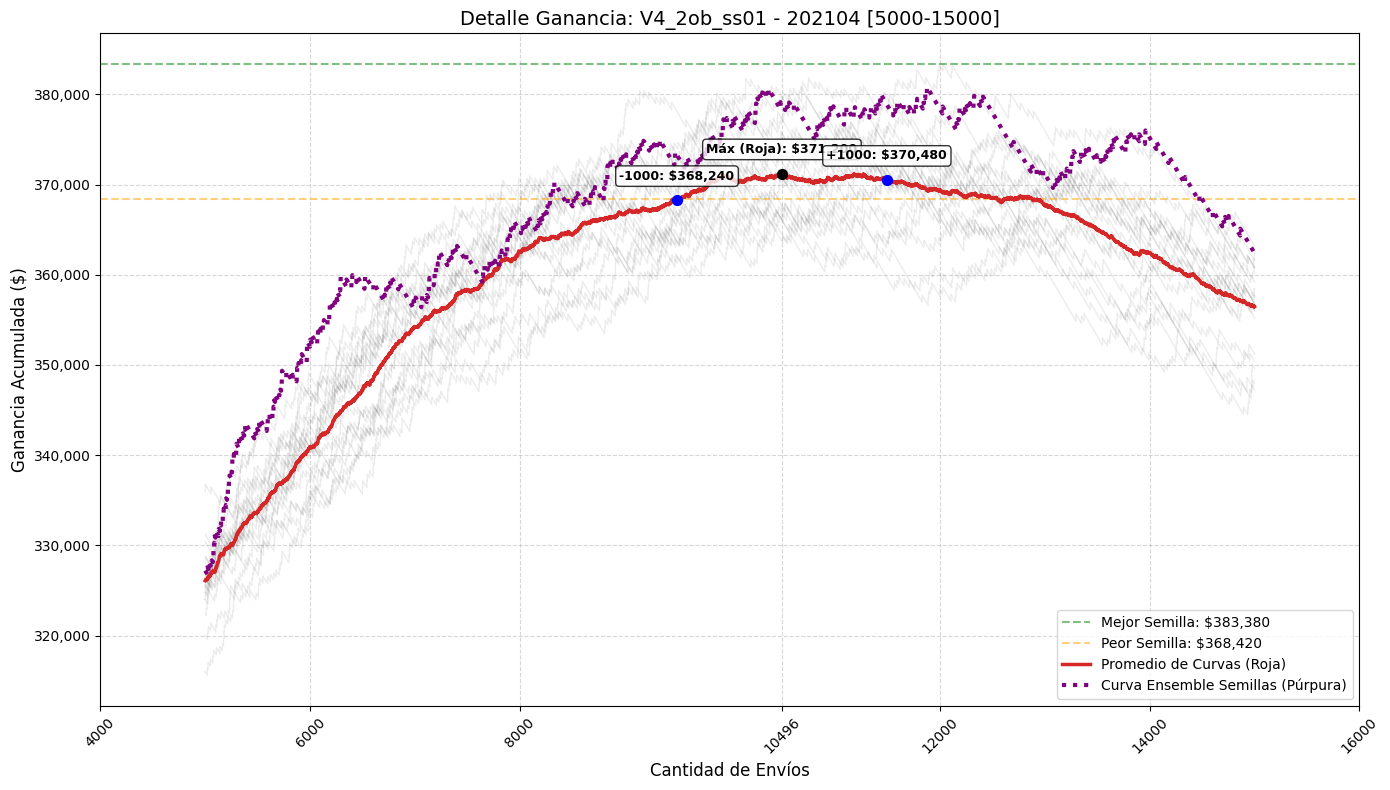

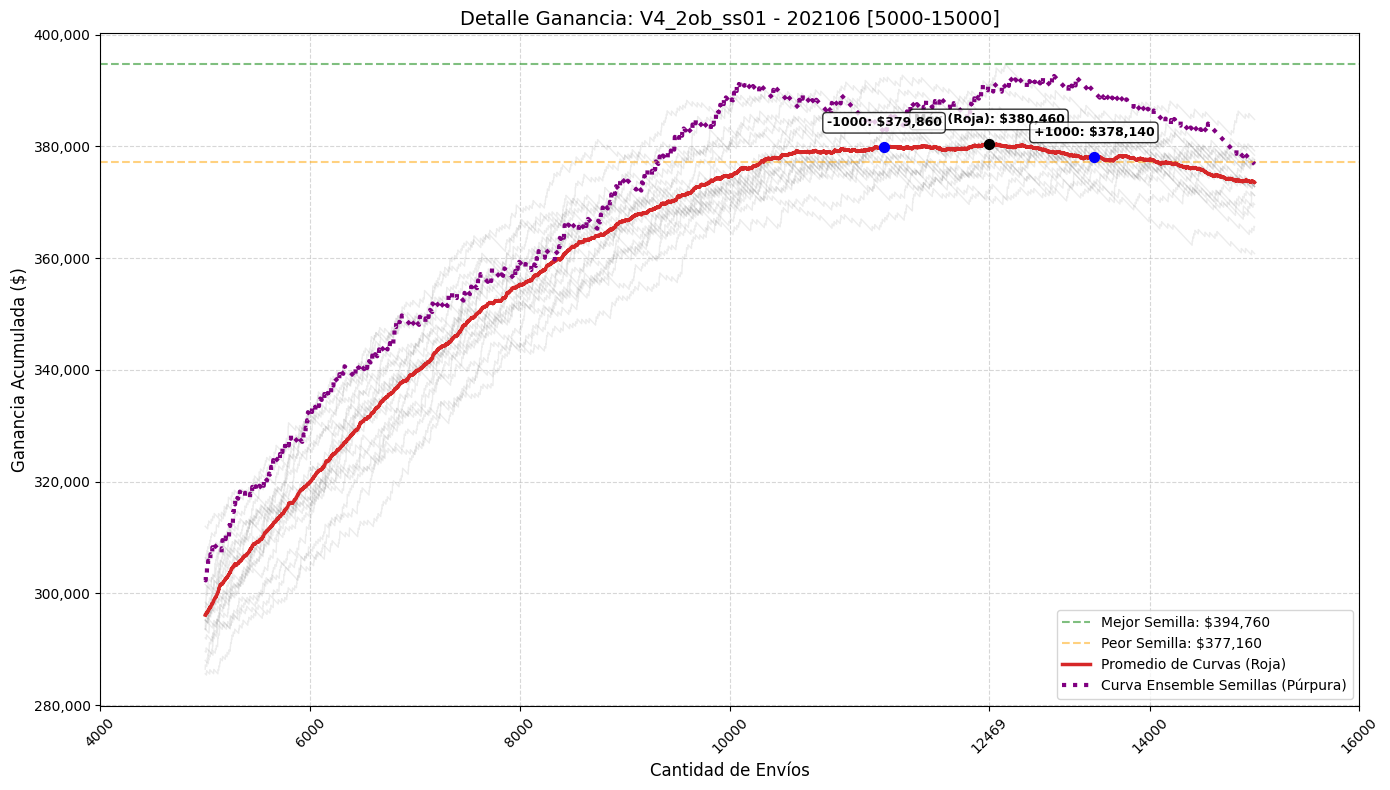

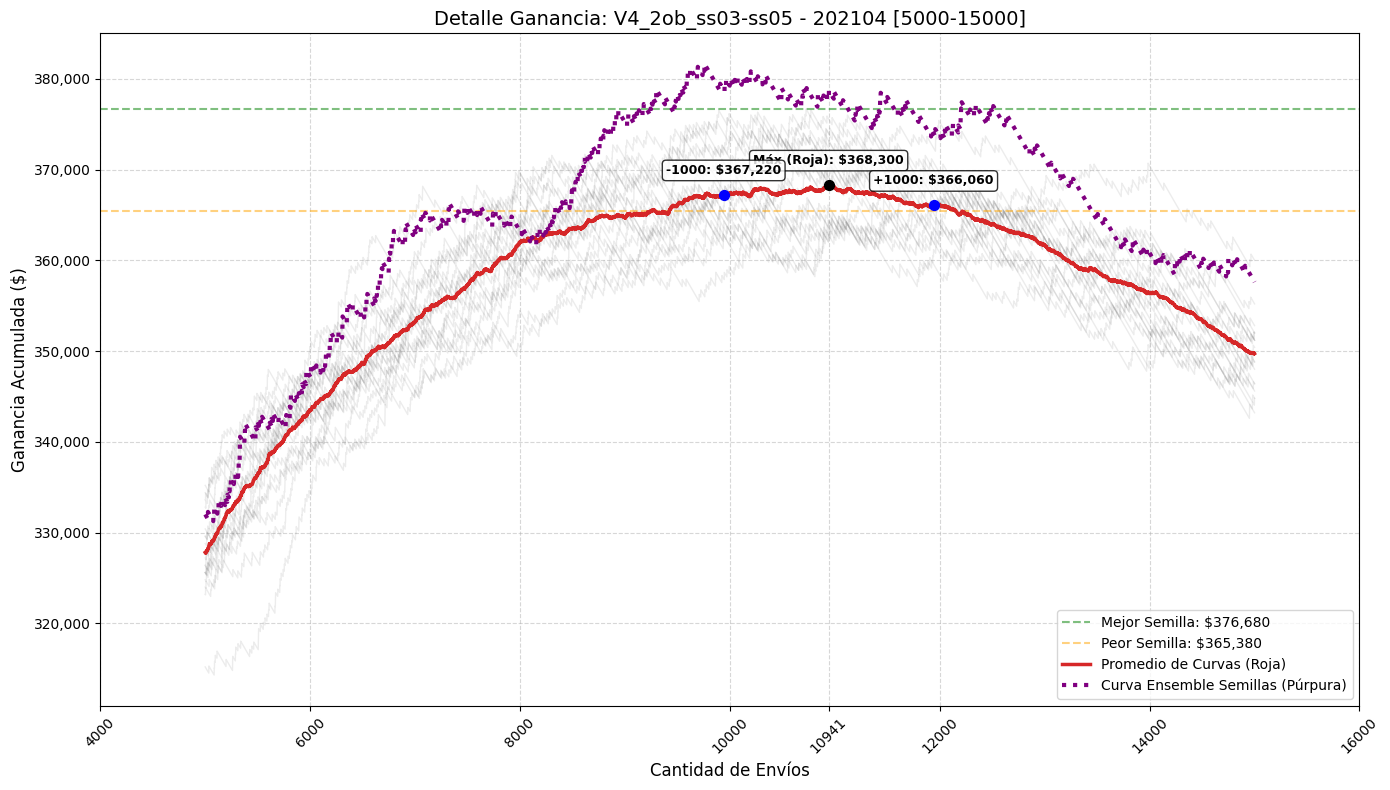

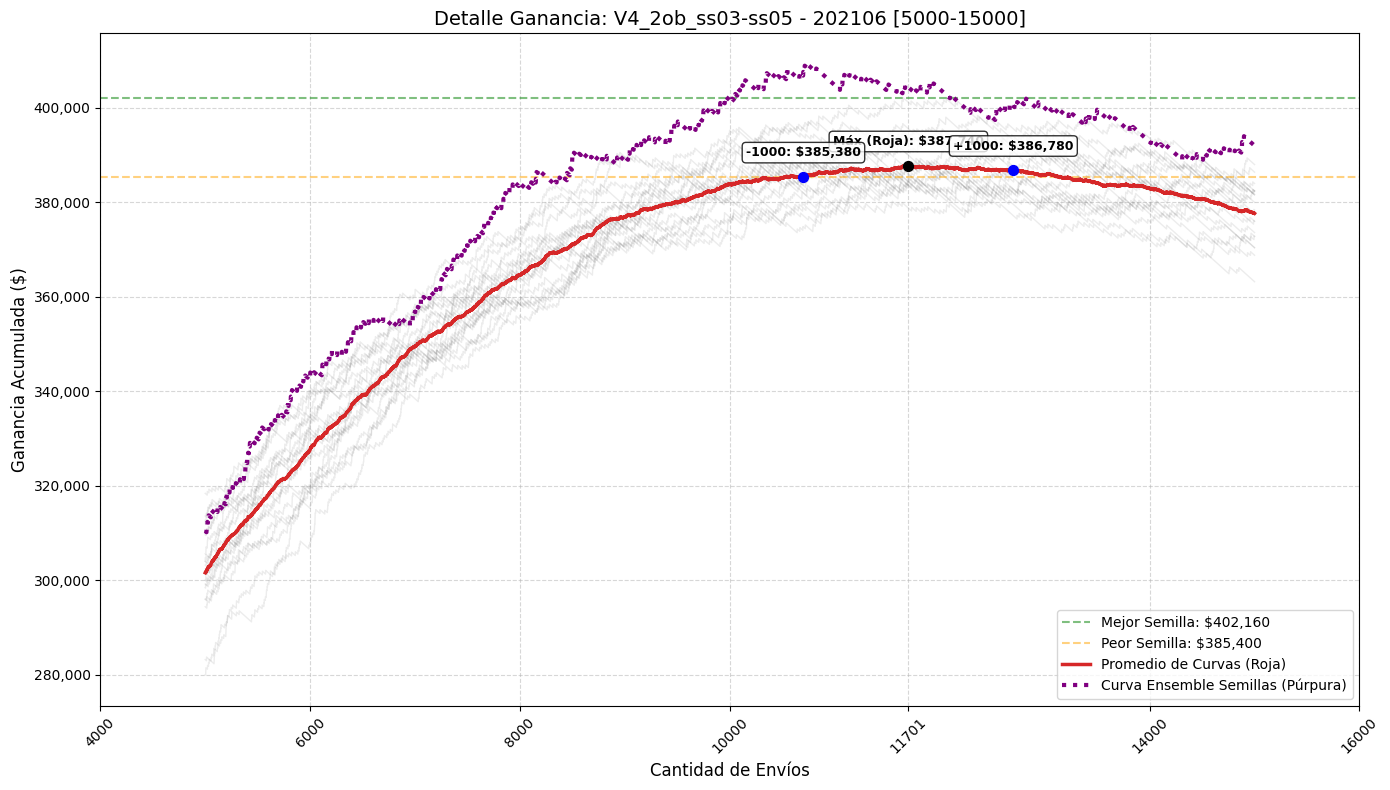

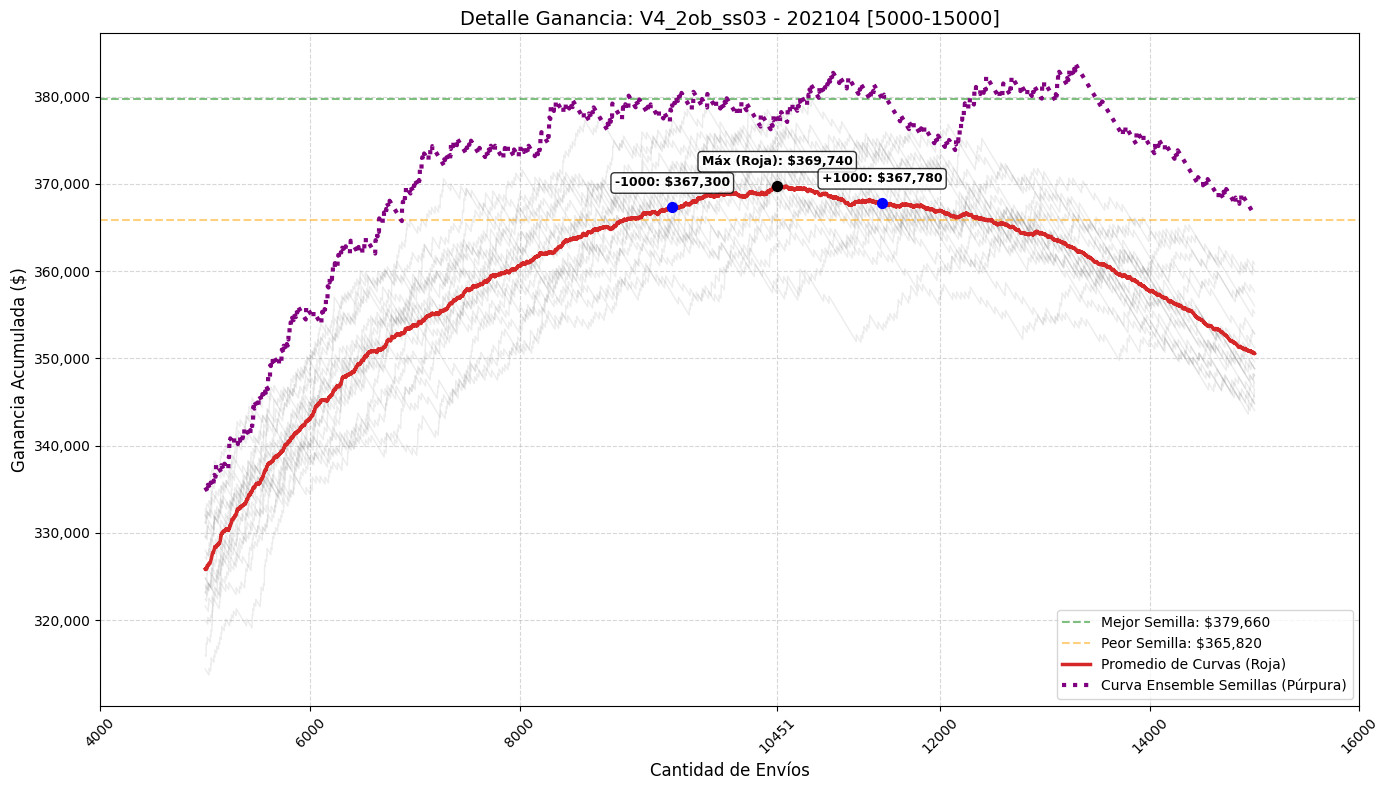

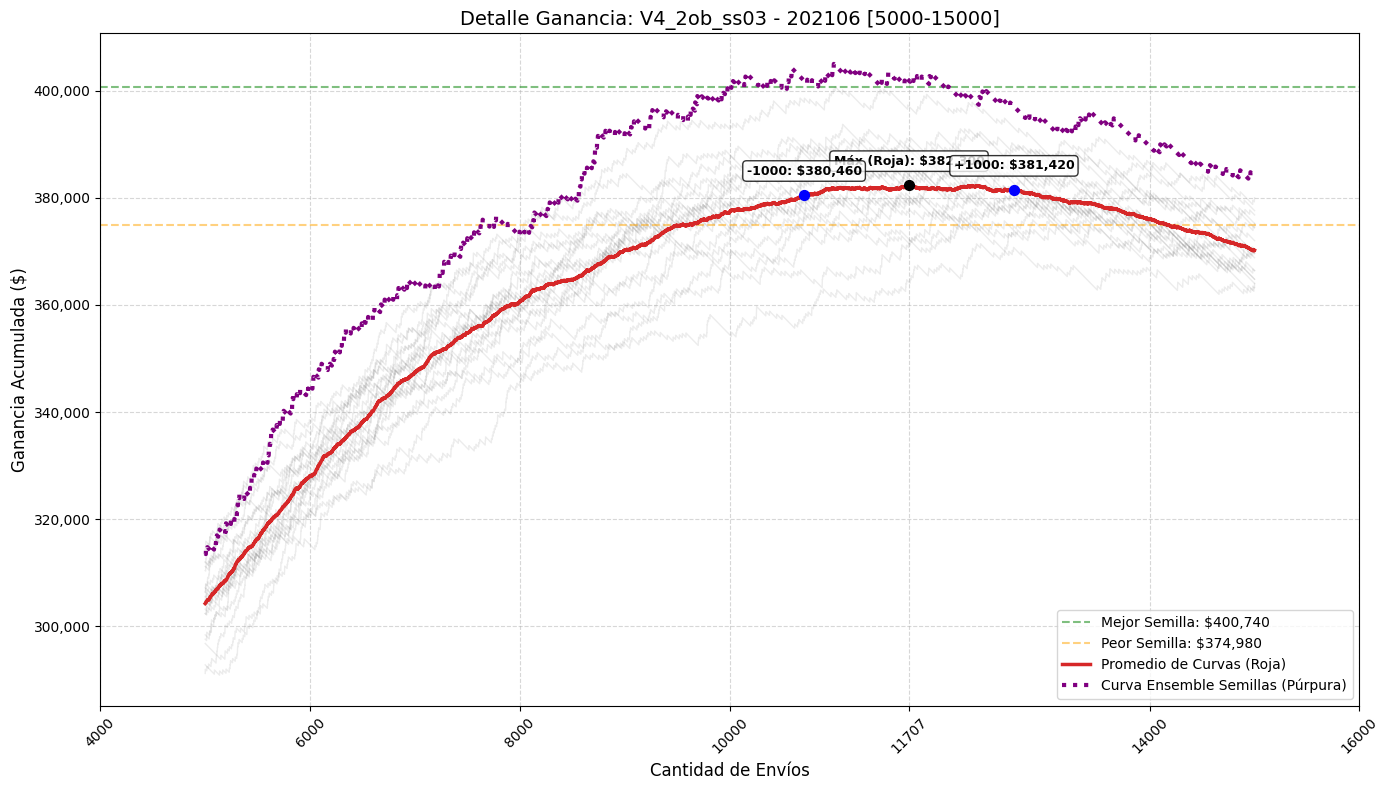


--- Generando Gráficos Comparativos (Promedios de Curvas) ---


C:\Users\terang\AppData\Local\Temp\ipykernel_26880\3105032140.py:156: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colores = plt.cm.get_cmap('tab10', 10)


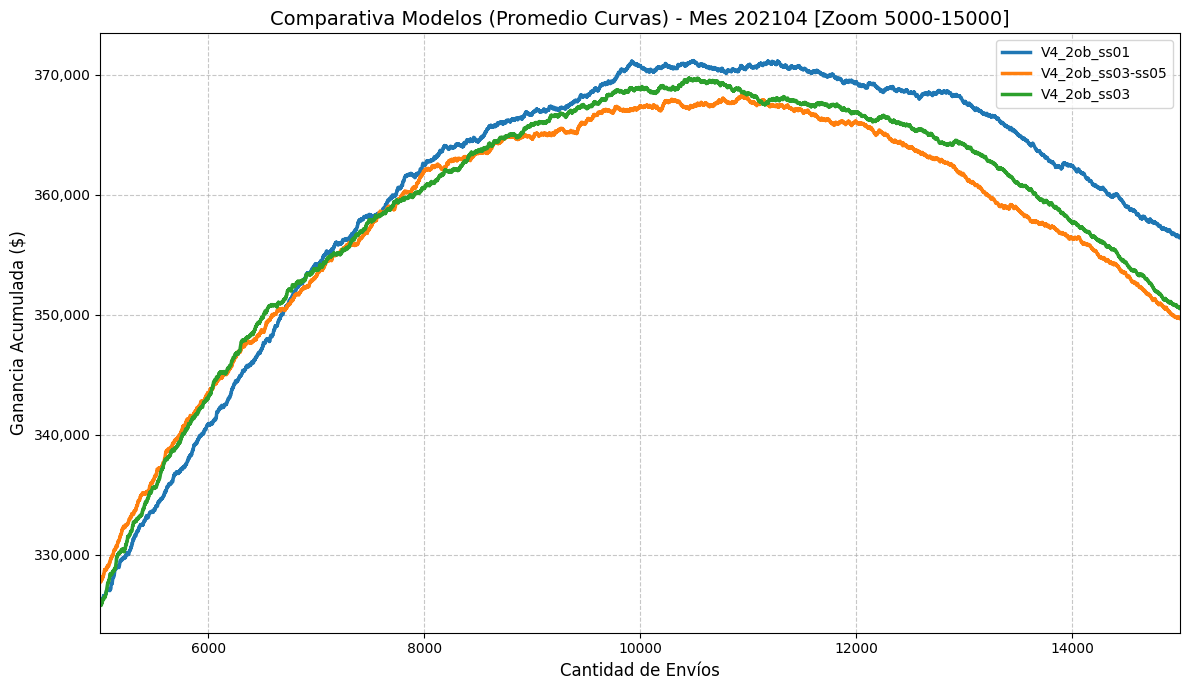

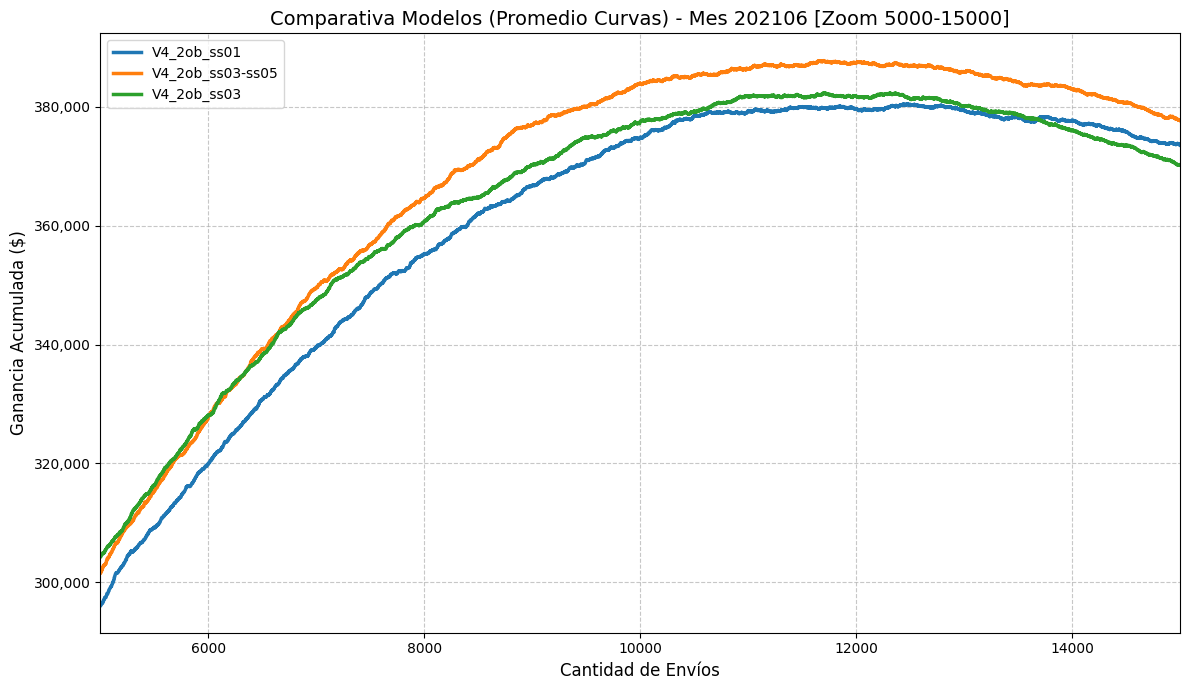


--- Generando Gráficos Comparativos (Ensemble de Semillas) ---


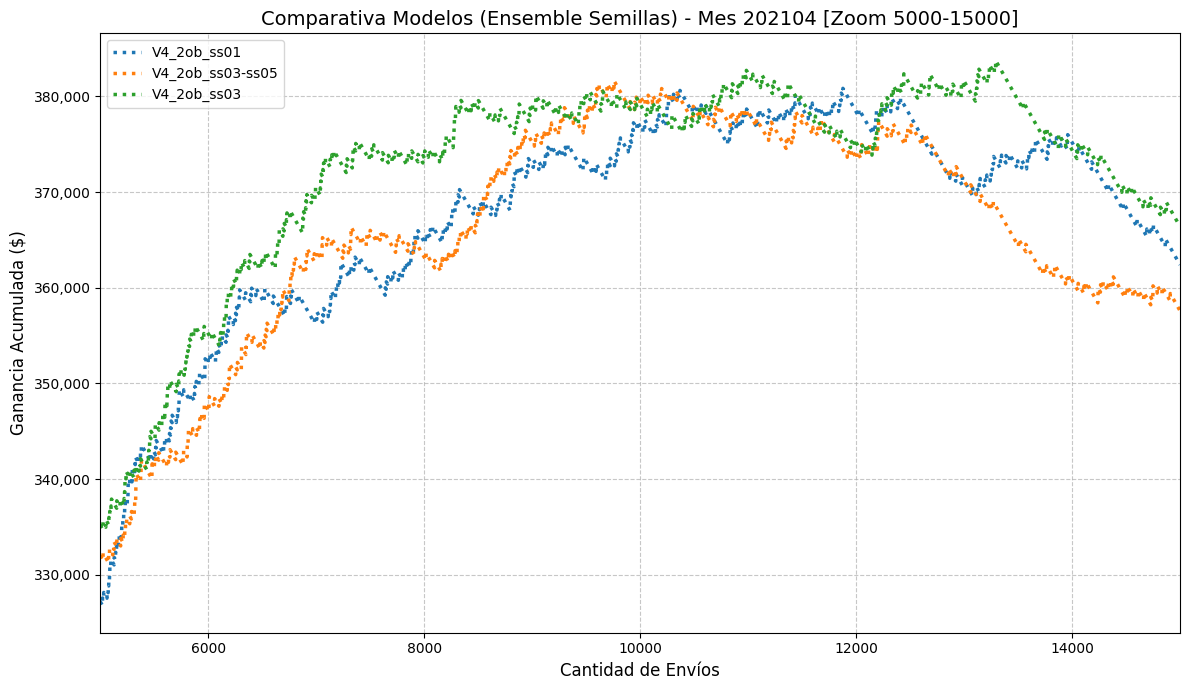

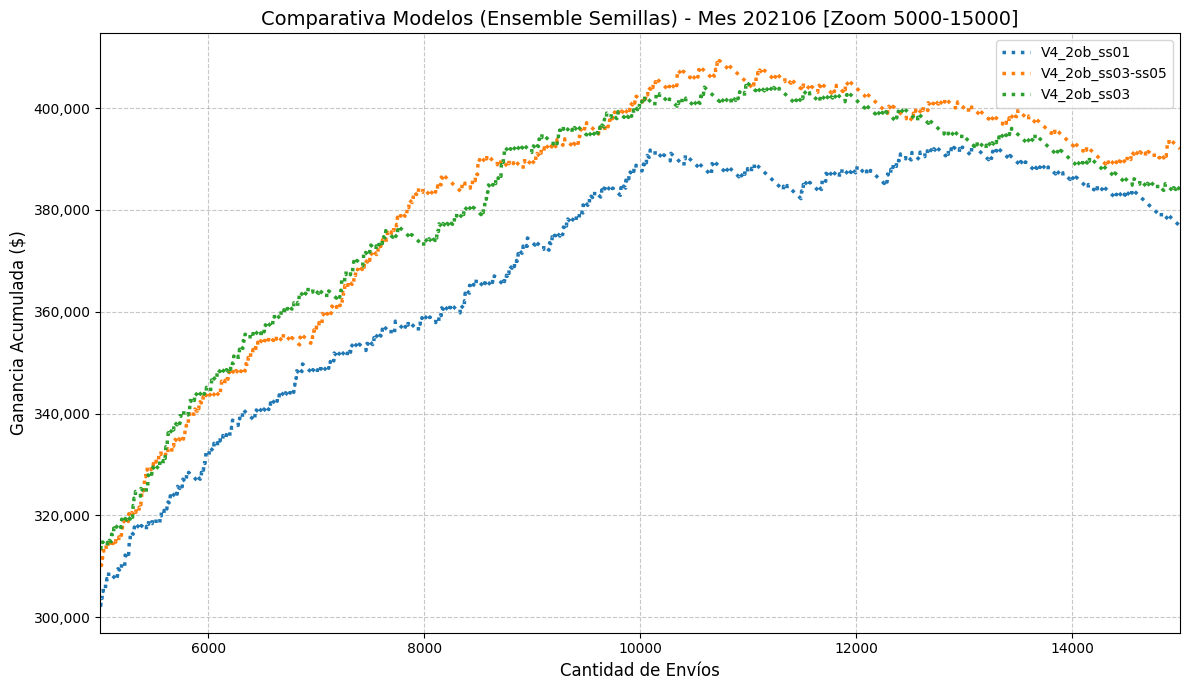


--- Iniciando Proceso de Ensemble ---
Cargando todos los archivos para el ensemble...
Paso 1: Calculando promedio por modelo (semillas)...
Paso 2: Calculando promedio de ensemble (modelos)...
Paso 3: Generando gráficos de ganancia del ensemble...


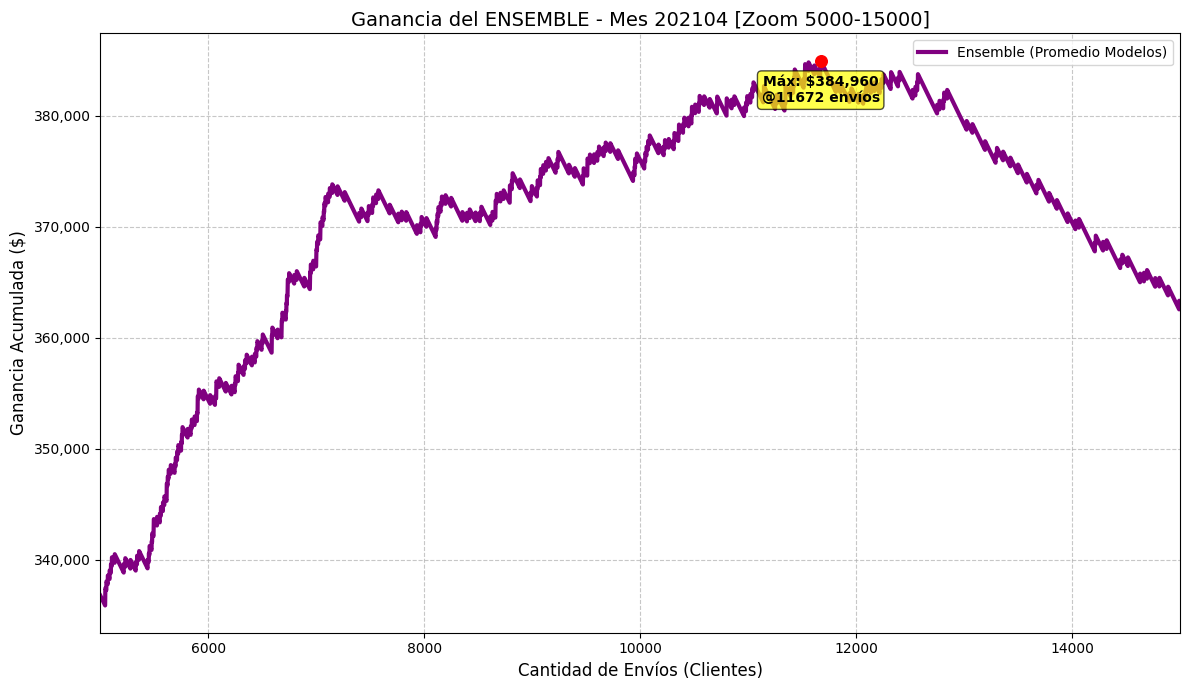

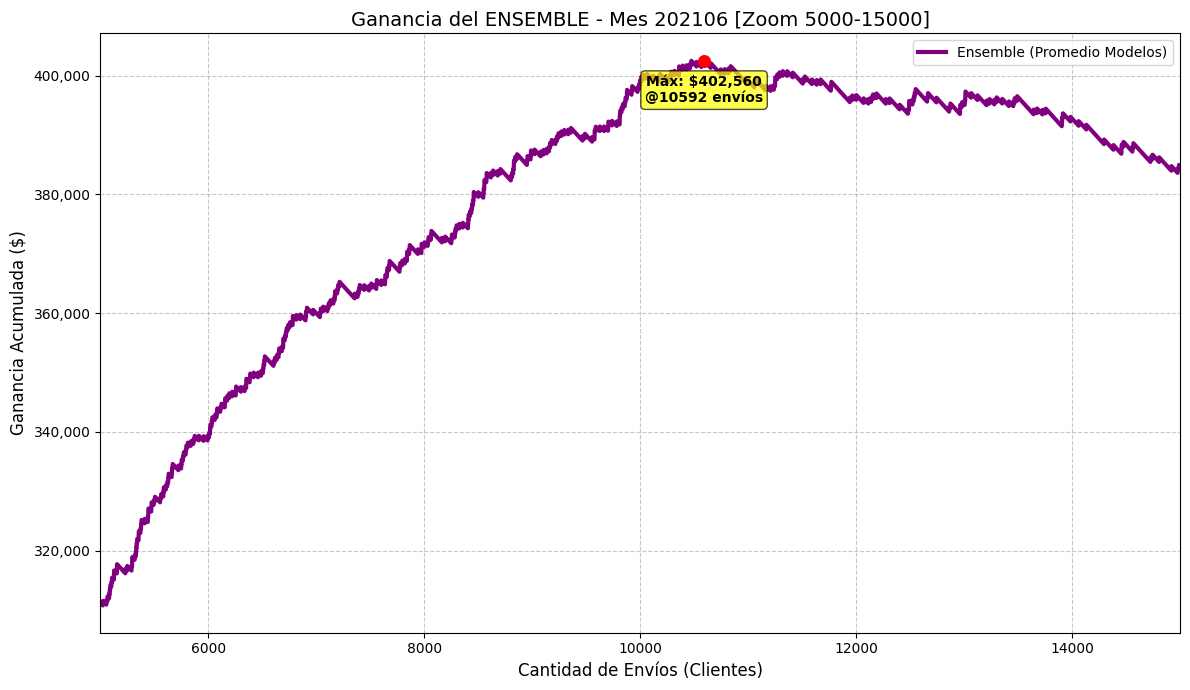

In [17]:
procesar_archivos()
    
    # 2. Ejecuta la nueva función (gráficos del ensemble)
graficar_ensemble(
    ruta_carpeta=RUTA_CARPETA,
    patron_regex=PATRON_REGEX,
    ganancia_unitaria=GANANCIA_UNITARIA,
    costo_unitario=COSTO_UNITARIO,
    x_lim_min=X_LIM_MIN,
    x_lim_max=X_LIM_MAX,
    y_lim_min=Y_LIM_MIN,
    y_lim_max=Y_LIM_MAX
)